In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# load dependencies
import sys
import pickle
import os
import shutil
import json
import pandas as pd
import numpy as np
import rdkit.Chem as Chem
from numpy.random import default_rng
import torch
from ast import literal_eval
from torch import nn, optim
from rdkit import Chem
from rdkit.Chem import AllChem
from tdc import Oracle
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
print(os.getcwd())

/home/springnuance/reinvent-hitl/Base-Code-Binh


In [13]:
from training_Bradley_Terry_model.bradley_terry import BradleyTerryModel
from training_Rank_ListNet_model.rank_listnet import RankListNetModel
from training_Score_Regression_model.score_regression import ScoreRegressionModel
from scripts.helper import load_drd2_dataset, write_REINVENT_config, change_config_json, \
                    read_scaffold_result, load_feedback_model, smiles_human_score, \
                    compute_fingerprints, retrain_feedback_model,\
                    create_drd2_dataset, combine_drd2_dataset, save_drd2_dataset
                        
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, matthews_corrcoef

### Loading analytics results

In [14]:
model_names = ["score_regression", "bradley_terry", "rank_listnet"]

models = {
    "score_regression": {},
    "bradley_terry": {},
    "rank_listnet": {}
}

# combined model means that it will concatenate all REINVENT rounds into one dataset

combined_models = {
    "score_regression": {},
    "bradley_terry": {},
    "rank_listnet": {}
}

for acquisition in ["random", "uncertainty", "greedy"]:
    for sigma_noise in [0.0, 0.1]:
        for i, model_name in enumerate(model_names):
            models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"] = {}
            combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"] = {}

            for prop_name in ["smiles_list", "metrics", "drd2_proba", "novelty_score", "sa_score", "qed_score",\
                            "logP", "mol_weight", "h_donors", "h_acceptors",\
                            "tpsa", "rotatable_bonds", "num_rings"]:
                
                result = np.load(f"results_{model_name}_n_steps_100/acq_{acquisition}_noise_{sigma_noise}_{prop_name}.npy", allow_pickle=True).tolist()
                #print(result)                
                models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name] = result

                if prop_name != "metrics":
                    prop_list = []

                    # EXCLUDING THE FIRST ROUND
                    for REINVENT_round in range(2, 5):
                        REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
                        #print(len(list(result[REINVENT_round_name])))
                        prop_list.extend(list(result[REINVENT_round_name]))
                    #print(len(prop_list))
                    combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name] = np.array(prop_list)

### Filter functions

In [15]:
from rdkit.Chem import Descriptors
from rdkit.Chem import Crippen
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import QED
from rdkit.Chem import DataStructs
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
# now you can import sascore!
import sascorer

def props_filter(props_dict, threshold_dict):
    smiles_list = props_dict["smiles_list"]
    drd2_proba = props_dict["drd2_proba"]
    novelty_score = props_dict["novelty_score"]
    sa_score = props_dict["sa_score"]
    qed_score = props_dict["qed_score"]
    logP = props_dict["logP"]
    mol_weight = props_dict["mol_weight"]
    h_donors = props_dict["h_donors"]
    h_acceptors = props_dict["h_acceptors"]
    tpsa = props_dict["tpsa"]
    rotatable_bonds = props_dict["rotatable_bonds"]
    num_rings = props_dict["num_rings"]

    drd2_proba_threshold = threshold_dict.get("drd2_proba", 0.75) # Average drd2 prob predicted by Oracle for molecules that actually have drd2
    novelty_score_threshold = threshold_dict.get("novelty_score", 0.5) #  common threshold for the novelty score is around 0.7, meaning that a molecule should have a Tanimoto similarity of less than 0.5 to any molecule in the reference set.
    sa_score_threshold = threshold_dict.get("sa_score", 3.0) # Range from 1 to 10. A common threshold for acceptability is an SA score of 6 or lower.
    qed_score_threshold = threshold_dict.get("qed_score", 0.5) # Range from 0 to 1. A common threshold for acceptability is a QED score of 0.5 or higher.
    logP_threshold = threshold_dict.get("logP", 5.0) # Lipinski's rule of five, less than 5
    mol_weight_threshold = threshold_dict.get("mol_weight", 500.0) # Lipinski's rule of five, less than 500
    h_donors_threshold = threshold_dict.get("h_donors", 5.0) # Lipinski's rule of five, less than 5
    h_acceptors_threshold = threshold_dict.get("h_acceptors", 10.0) # Lipinski's rule of five, less than 10
    tpsa_threshold = threshold_dict.get("tpsa", 140.0) # Veber's rule, less than 140
    rotatable_bonds_threshold = threshold_dict.get("rotatable_bonds", 10.0) # Veber's rule, less than 10
    num_rings_threshold = threshold_dict.get("num_rings", 7) # Muegge's rule, less than 7

    props_dict_filtered = {}
    percentage_dict = {}
    means_dict = {}

    # Strategy: we need to find the indices that satisfy each condition, and then take the intersection of all of them

    # drd2_proba
    drd2_proba_indices = np.where(drd2_proba > drd2_proba_threshold)[0]
    satisfied_drd2_proba = len(drd2_proba_indices) / len(drd2_proba)

    novelty_score_indices = np.where(novelty_score > novelty_score_threshold)[0]
    satisfied_novelty_score = len(novelty_score_indices) / len(novelty_score)

    sa_score_indices = np.where(sa_score < sa_score_threshold)[0]
    satisfied_sa_score = len(sa_score_indices) / len(sa_score)

    qed_score_indices = np.where(qed_score > qed_score_threshold)[0]
    satisfied_qed_score = len(qed_score_indices) / len(qed_score)
    
    # logP additionally should be larger than 1. We use two conditions in the np.where
    logP_indices = np.where((logP < logP_threshold) & (logP > 1))[0]
    satisfied_logP = len(logP_indices) / len(logP)

    mol_weight_indices = np.where(mol_weight < mol_weight_threshold)[0]
    satisfied_mol_weight = len(mol_weight_indices) / len(mol_weight)

    h_donors_indices = np.where(h_donors < h_donors_threshold)[0]
    satisfied_h_donors = len(h_donors_indices) / len(h_donors)

    h_acceptors_indices = np.where(h_acceptors < h_acceptors_threshold)[0]
    satisfied_h_acceptors = len(h_acceptors_indices) / len(h_acceptors)

    tpsa_indices = np.where(tpsa < tpsa_threshold)[0]
    satisfied_tpsa = len(tpsa_indices) / len(tpsa)

    rotatable_bonds_indices = np.where(rotatable_bonds < rotatable_bonds_threshold)[0]
    satisfied_rotatable_bonds = len(rotatable_bonds_indices) / len(rotatable_bonds)

    num_rings_indices = np.where(num_rings < num_rings_threshold)[0]
    satisfied_num_rings = len(num_rings_indices) / len(num_rings)

    # Finding the intersection of all index arrays
    common_indices = drd2_proba_indices
    
    for indices in [
        novelty_score_indices,
        sa_score_indices,
        qed_score_indices,
        logP_indices,
        mol_weight_indices,
        h_donors_indices,
        h_acceptors_indices,
        tpsa_indices,
        rotatable_bonds_indices,
        num_rings_indices
    ]:
        common_indices = np.intersect1d(common_indices, indices)

    props_dict_filtered["smiles_list"] = smiles_list[common_indices]
    props_dict_filtered["drd2_proba"] = drd2_proba[common_indices]
    props_dict_filtered["novelty_score"] = novelty_score[common_indices]
    props_dict_filtered["sa_score"] = sa_score[common_indices]
    props_dict_filtered["qed_score"] = qed_score[common_indices]
    props_dict_filtered["logP"] = logP[common_indices]
    props_dict_filtered["mol_weight"] = mol_weight[common_indices]
    props_dict_filtered["h_donors"] = h_donors[common_indices]
    props_dict_filtered["h_acceptors"] = h_acceptors[common_indices]
    props_dict_filtered["tpsa"] = tpsa[common_indices]
    props_dict_filtered["rotatable_bonds"] = rotatable_bonds[common_indices]
    props_dict_filtered["num_rings"] = num_rings[common_indices]

    percentage_dict["smiles_list"] = len(common_indices) / len(smiles_list)
    percentage_dict["drd2_proba"] = satisfied_drd2_proba
    percentage_dict["novelty_score"] = satisfied_novelty_score
    percentage_dict["sa_score"] = satisfied_sa_score
    percentage_dict["qed_score"] = satisfied_qed_score
    percentage_dict["logP"] = satisfied_logP
    percentage_dict["mol_weight"] = satisfied_mol_weight
    percentage_dict["h_donors"] = satisfied_h_donors
    percentage_dict["h_acceptors"] = satisfied_h_acceptors
    percentage_dict["tpsa"] = satisfied_tpsa
    percentage_dict["rotatable_bonds"] = satisfied_rotatable_bonds
    percentage_dict["num_rings"] = satisfied_num_rings

    means_dict["smiles_list"] = len(common_indices)
    means_dict["drd2_proba"] = np.mean(drd2_proba[common_indices])
    means_dict["novelty_score"] = np.mean(novelty_score[common_indices])
    means_dict["sa_score"] = np.mean(sa_score[common_indices])
    means_dict["qed_score"] = np.mean(qed_score[common_indices])
    means_dict["logP"] = np.mean(logP[common_indices])
    means_dict["mol_weight"] = np.mean(mol_weight[common_indices])
    means_dict["h_donors"] = np.mean(h_donors[common_indices])
    means_dict["h_acceptors"] = np.mean(h_acceptors[common_indices])
    means_dict["tpsa"] = np.mean(tpsa[common_indices])
    means_dict["rotatable_bonds"] = np.mean(rotatable_bonds[common_indices])
    means_dict["num_rings"] = np.mean(num_rings[common_indices])
    
    return props_dict_filtered, percentage_dict, means_dict

In [16]:
import copy

model_names = ["score_regression", "bradley_terry", "rank_listnet"]
model_names_mapping = {
    "score_regression": "scoring",
    "bradley_terry": "comparing",
    "rank_listnet": "ranking"
}
prop_names = ["smiles_list", "drd2_proba", "novelty_score", "sa_score", "qed_score", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"]

filtered_models = copy.deepcopy(models)

summary_percentage = pd.DataFrame(columns=["num_filtered_mols", "drd2_proba", "novelty_score", "sa_score", "qed_score", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"])
summary_mean = pd.DataFrame(columns=["num_filtered_mols", "drd2_proba", "novelty_score", "sa_score", "qed_score", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"])

for i, model_name in enumerate(model_names):
    for acquisition in ["random", "uncertainty", "greedy"]:
        for sigma_noise in [0.0, 0.1]:
            for REINVENT_round in [4]:
                REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
                props_dict = {}
                for prop_name in prop_names:
                    #print(prop_name)
                    props_dict[prop_name] = models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name][REINVENT_round_name]

                props_dict["smiles_list"] = models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["smiles_list"][REINVENT_round_name]
                
                threshold_dict = {} # We will use the default thresholds
                props_dict_filtered, percentage_dict, means_dict = props_filter(props_dict, threshold_dict)
                #print(means_dict)
                if REINVENT_round == 4:
                    #print(percentage_dict)
                    summary_percentage.loc[f"{model_names_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}", "num_filtered_mols"] = len(props_dict_filtered["smiles_list"])
                    summary_mean.loc[f"{model_names_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}", "num_filtered_mols"] = len(props_dict_filtered["smiles_list"])
                    for prop_name in percentage_dict.keys():
                        if prop_name != "smiles_list":
                            summary_percentage.loc[f"{model_names_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}", prop_name] = percentage_dict[prop_name]
                    for prop_name in means_dict.keys():
                        if prop_name != "smiles_list":
                            summary_mean.loc[f"{model_names_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}", prop_name] = means_dict[prop_name]
                for prop_name in prop_names:
                    filtered_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name][REINVENT_round_name] = props_dict_filtered[prop_name]

print("Summary of percentage of molecules that satisfy each respective threshold at last REINVENT round")
summary_percentage = summary_percentage.apply(pd.to_numeric, errors='coerce')  # Convert all other data to numeric, coercing errors
summary_percentage.head(30)

Summary of percentage of molecules that satisfy each respective threshold at last REINVENT round


,num_filtered_mols,drd2_proba,novelty_score,sa_score,qed_score,logP,mol_weight,h_donors,h_acceptors,tpsa,rotatable_bonds,num_rings
scoring | random acq | noise 0.0,102,0.069515,0.957512,0.382883,0.259800,0.480034,0.407719,0.957512,0.903092,0.926710,0.618456,0.772340
scoring | random acq | noise 0.1,227,0.413018,0.354413,0.958073,0.491545,0.539727,0.724114,1.000000,0.999073,1.000000,0.536020,0.997220
scoring | uncertainty acq | noise 0.0,241,0.435421,0.421161,0.796446,0.425708,0.598677,0.627609,0.999793,0.865468,0.987601,0.489771,0.946477
scoring | uncertainty acq | noise 0.1,361,0.403616,0.592511,0.871795,0.790076,0.770891,0.903339,0.999816,0.999078,1.000000,0.938572,0.990039
scoring | greedy acq | noise 0.0,395,0.500494,0.486070,0.853784,0.499704,0.580913,0.668247,0.997827,0.989725,0.999605,0.583877,0.971350
scoring | greedy acq | noise 0.1,255,0.512884,0.437161,0.925407,0.681058,0.731239,0.868671,0.998870,0.998870,0.999548,0.799729,0.995931
comparing | random acq | noise 0.0,355,0.146818,0.871193,0.720631,0.814125,0.772943,0.947486,0.992715,0.996863,0.993625,0.976323,0.989578
comparing | random acq | noise 0.1,353,0.147374,0.852828,0.712121,0.752929,0.738182,0.909495,0.992020,0.997576,0.994040,0.872929,0.985556
comparing | uncertainty acq | noise 0.0,374,0.124685,0.900413,0.671404,0.807882,0.790948,0.949602,0.992843,0.996069,0.994456,0.946780,0.986191
comparing | uncertainty acq | noise 0.1,391,0.166013,0.877902,0.711587,0.710381,0.740830,0.888554,0.988845,0.995578,0.992966,0.886343,0.984725


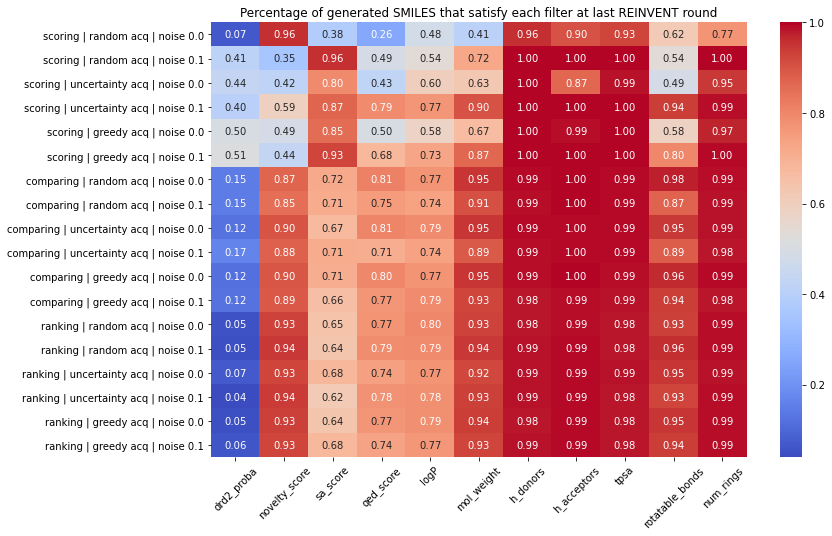

In [17]:
# We'll drop the 'num_filtered_mols' column if you only want to visualize the properties

data_for_heatmap = summary_percentage.drop(['num_filtered_mols'], axis=1)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data_for_heatmap, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Percentage of generated SMILES that satisfy each filter at last REINVENT round')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [18]:
print("Summary of mean of properties of molecules that satisfy each respective threshold at last REINVENT round")
summary_mean.head(30)

Summary of mean of properties of molecules that satisfy each respective threshold at last REINVENT round


,num_filtered_mols,drd2_proba,novelty_score,sa_score,qed_score,logP,mol_weight,h_donors,h_acceptors,tpsa,rotatable_bonds,num_rings
scoring | random acq | noise 0.0,102,0.910125,0.601773,2.532179,0.663599,3.847954,402.512569,0.77451,4.264706,42.987843,5.813725,4.235294
scoring | random acq | noise 0.1,227,0.935989,0.564755,2.26646,0.688271,4.000962,375.895278,0.396476,3.303965,20.803216,6.334802,3.612335
scoring | uncertainty acq | noise 0.0,241,0.945499,0.560066,2.349693,0.674388,3.841824,385.439697,0.452282,4.120332,32.411452,6.207469,3.983402
scoring | uncertainty acq | noise 0.1,361,0.925892,0.56909,2.355755,0.717816,3.854562,382.902701,0.551247,3.731302,31.496288,5.409972,3.919668
scoring | greedy acq | noise 0.0,395,0.947459,0.5601,2.398858,0.688413,3.850715,391.018223,0.481013,3.825316,30.513848,6.022785,3.901266
scoring | greedy acq | noise 0.1,255,0.933332,0.55779,2.317138,0.70185,3.909784,375.724616,0.811765,3.6,32.776314,5.654902,3.709804
comparing | random acq | noise 0.0,355,0.911015,0.582508,2.355976,0.74569,3.904257,368.603023,0.521127,3.278873,26.094704,4.667606,3.864789
comparing | random acq | noise 0.1,353,0.914693,0.595806,2.402773,0.730508,3.844541,361.383575,0.685552,3.212465,29.385354,5.271955,3.827195
comparing | uncertainty acq | noise 0.0,374,0.899942,0.598215,2.43182,0.736378,3.758435,348.883567,0.553476,3.307487,29.125481,4.764706,3.775401
comparing | uncertainty acq | noise 0.1,391,0.914842,0.588727,2.438516,0.695384,3.949118,378.275711,0.693095,3.644501,33.562251,5.624041,3.897698


In [19]:
import copy

model_names = ["score_regression", "bradley_terry", "rank_listnet"]
prop_names = ["smiles_list", "drd2_proba", "novelty_score", "sa_score", "qed_score", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"]

model_names_mapping = {
    "score_regression": "scoring",
    "bradley_terry": "comparing",
    "rank_listnet": "ranking"
}
filtered_combined_models = copy.deepcopy(combined_models)

summary_percentage = pd.DataFrame(columns=["num_filtered_mols", "drd2_proba", "novelty_score", "sa_score", "qed_score", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"])
summary_mean = pd.DataFrame(columns=["num_filtered_mols", "drd2_proba", "novelty_score", "sa_score", "qed_score", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"])

for i, model_name in enumerate(model_names):
    for acquisition in ["random", "uncertainty", "greedy"]:
        for sigma_noise in [0.0, 0.1]:

            props_dict = {}
            for prop_name in prop_names:
                #print(prop_name)
                props_dict[prop_name] = combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name]

            props_dict["smiles_list"] = combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["smiles_list"]
            
            threshold_dict = {} # We will use the default thresholds
            props_dict_filtered, percentage_dict, means_dict = props_filter(props_dict, threshold_dict)
            
            summary_percentage.loc[f"{model_names_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}", "num_filtered_mols"] = len(props_dict_filtered["smiles_list"])
            summary_mean.loc[f"{model_names_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}", "num_filtered_mols"] = len(props_dict_filtered["smiles_list"])

            summary_percentage.loc[f"{model_names_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}", "all filters"] = percentage_dict["smiles_list"]
            for prop_name in percentage_dict.keys():
                if prop_name != "smiles_list":
                    summary_percentage.loc[f"{model_names_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}", prop_name] = percentage_dict[prop_name]
            
            for prop_name in means_dict.keys():
                if prop_name != "smiles_list":
                    summary_mean.loc[f"{model_names_mapping[model_name]} | {acquisition} acq | noise {sigma_noise}", prop_name] = means_dict[prop_name]
            for prop_name in prop_names:
                filtered_combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name] = props_dict_filtered[prop_name]

print("Summary of percentage of molecules that satisfy each respective threshold at all REINVENT rounds except round 1")
summary_percentage = summary_percentage.apply(pd.to_numeric, errors='coerce')  # Convert all other data to numeric, coercing errors
summary_percentage.head(30)

Summary of percentage of molecules that satisfy each respective threshold at all REINVENT rounds except round 1


,num_filtered_mols,drd2_proba,novelty_score,sa_score,qed_score,logP,mol_weight,h_donors,h_acceptors,tpsa,rotatable_bonds,num_rings,all filters
scoring | random acq | noise 0.0,294,0.110876,0.930120,0.462307,0.360918,0.537439,0.521684,0.967051,0.929527,0.946468,0.679485,0.829917,0.024903
scoring | random acq | noise 0.1,257,0.162348,0.729878,0.751330,0.626823,0.688090,0.845976,0.984984,0.991076,0.975974,0.785910,0.994680,0.022053
scoring | uncertainty acq | noise 0.0,305,0.138001,0.800871,0.688991,0.650644,0.729723,0.845957,0.985031,0.953364,0.976920,0.817629,0.978531,0.018189
scoring | uncertainty acq | noise 0.1,418,0.143295,0.837007,0.714792,0.760675,0.776230,0.921686,0.985586,0.993154,0.980962,0.939283,0.991292,0.025104
scoring | greedy acq | noise 0.0,451,0.175271,0.802411,0.706214,0.654589,0.714808,0.836016,0.985570,0.989547,0.979542,0.821971,0.985186,0.028923
scoring | greedy acq | noise 0.1,320,0.163110,0.800432,0.726862,0.726404,0.765872,0.917070,0.987957,0.993520,0.982524,0.902932,0.993258,0.020945
comparing | random acq | noise 0.0,496,0.098602,0.906325,0.676740,0.773884,0.773331,0.931315,0.987782,0.994167,0.989240,0.952987,0.988938,0.024940
comparing | random acq | noise 0.1,535,0.100953,0.896939,0.685148,0.754039,0.755544,0.917210,0.987908,0.994380,0.989865,0.904315,0.986754,0.026844
comparing | uncertainty acq | noise 0.0,542,0.090226,0.922306,0.654135,0.780852,0.779649,0.936842,0.989173,0.994637,0.990627,0.942857,0.987018,0.027168
comparing | uncertainty acq | noise 0.1,548,0.108253,0.911803,0.668522,0.719414,0.755315,0.900120,0.986412,0.993081,0.987515,0.914561,0.984757,0.027477


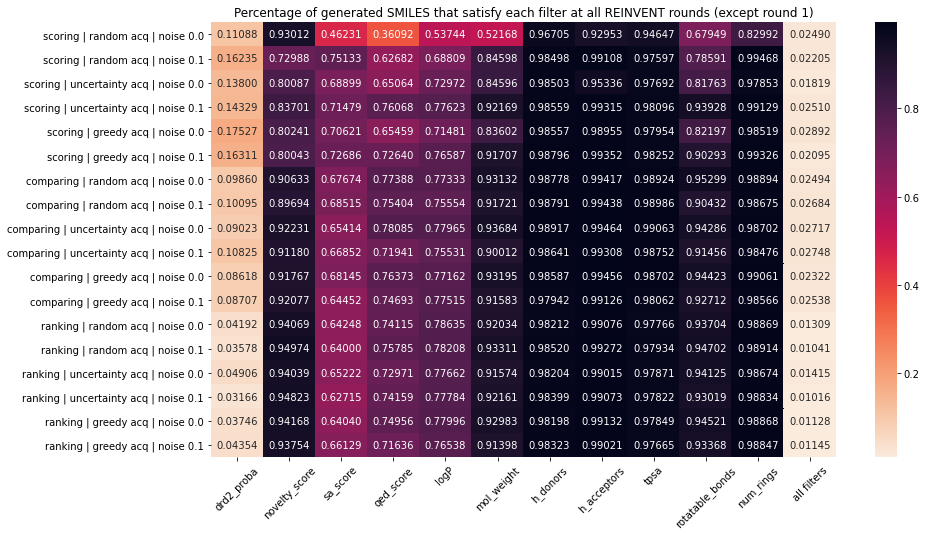

In [20]:
# We'll drop the 'num_filtered_mols' column if you only want to visualize the properties

data_for_heatmap = summary_percentage.drop(['num_filtered_mols'], axis=1)

# Create the heatmap
plt.figure(figsize=(14, 8))
# We use heatmap of only 1 color range since this is not contrastive
sns.heatmap(data_for_heatmap, annot=True, cmap= 'rocket_r', fmt=".5f")
plt.title(f'Percentage of generated SMILES that satisfy each filter at all REINVENT rounds (except round 1)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [21]:
print("Summary of mean of properties of molecules that satisfy all thresholds at all REINVENT rounds except round 1")
summary_mean.head(30)

Summary of mean of properties of molecules that satisfy all thresholds at all REINVENT rounds except round 1


,num_filtered_mols,drd2_proba,novelty_score,sa_score,qed_score,logP,mol_weight,h_donors,h_acceptors,tpsa,rotatable_bonds,num_rings
scoring | random acq | noise 0.0,294,0.909713,0.596154,2.490012,0.706137,3.844612,381.009585,0.721088,3.751701,36.61102,5.554422,3.982993
scoring | random acq | noise 0.1,257,0.93036,0.569786,2.300287,0.691285,3.983249,374.280346,0.447471,3.311284,22.887665,6.155642,3.614786
scoring | uncertainty acq | noise 0.0,305,0.933863,0.566993,2.348516,0.685049,3.813117,378.843666,0.518033,3.954098,33.118066,5.954098,3.898361
scoring | uncertainty acq | noise 0.1,418,0.922585,0.573455,2.374972,0.721265,3.832009,377.873194,0.595694,3.686603,32.350096,5.344498,3.870813
scoring | greedy acq | noise 0.0,451,0.93853,0.565755,2.414275,0.697351,3.803695,385.512009,0.527716,3.782705,31.311707,5.831486,3.866962
scoring | greedy acq | noise 0.1,320,0.926943,0.569056,2.348946,0.707133,3.883054,372.566622,0.840625,3.559375,34.133688,5.465625,3.73125
comparing | random acq | noise 0.0,496,0.90575,0.587602,2.379828,0.742856,3.861918,365.027911,0.612903,3.272177,28.419577,4.830645,3.800403
comparing | random acq | noise 0.1,535,0.907266,0.59885,2.436139,0.724725,3.818939,365.005243,0.715888,3.385047,32.229944,5.201869,3.829907
comparing | uncertainty acq | noise 0.0,542,0.901353,0.598126,2.438854,0.731952,3.761849,354.349389,0.583026,3.380074,31.11821,4.824723,3.782288
comparing | uncertainty acq | noise 0.1,548,0.909759,0.593563,2.456532,0.700432,3.901152,374.534588,0.737226,3.618613,34.75365,5.403285,3.89781


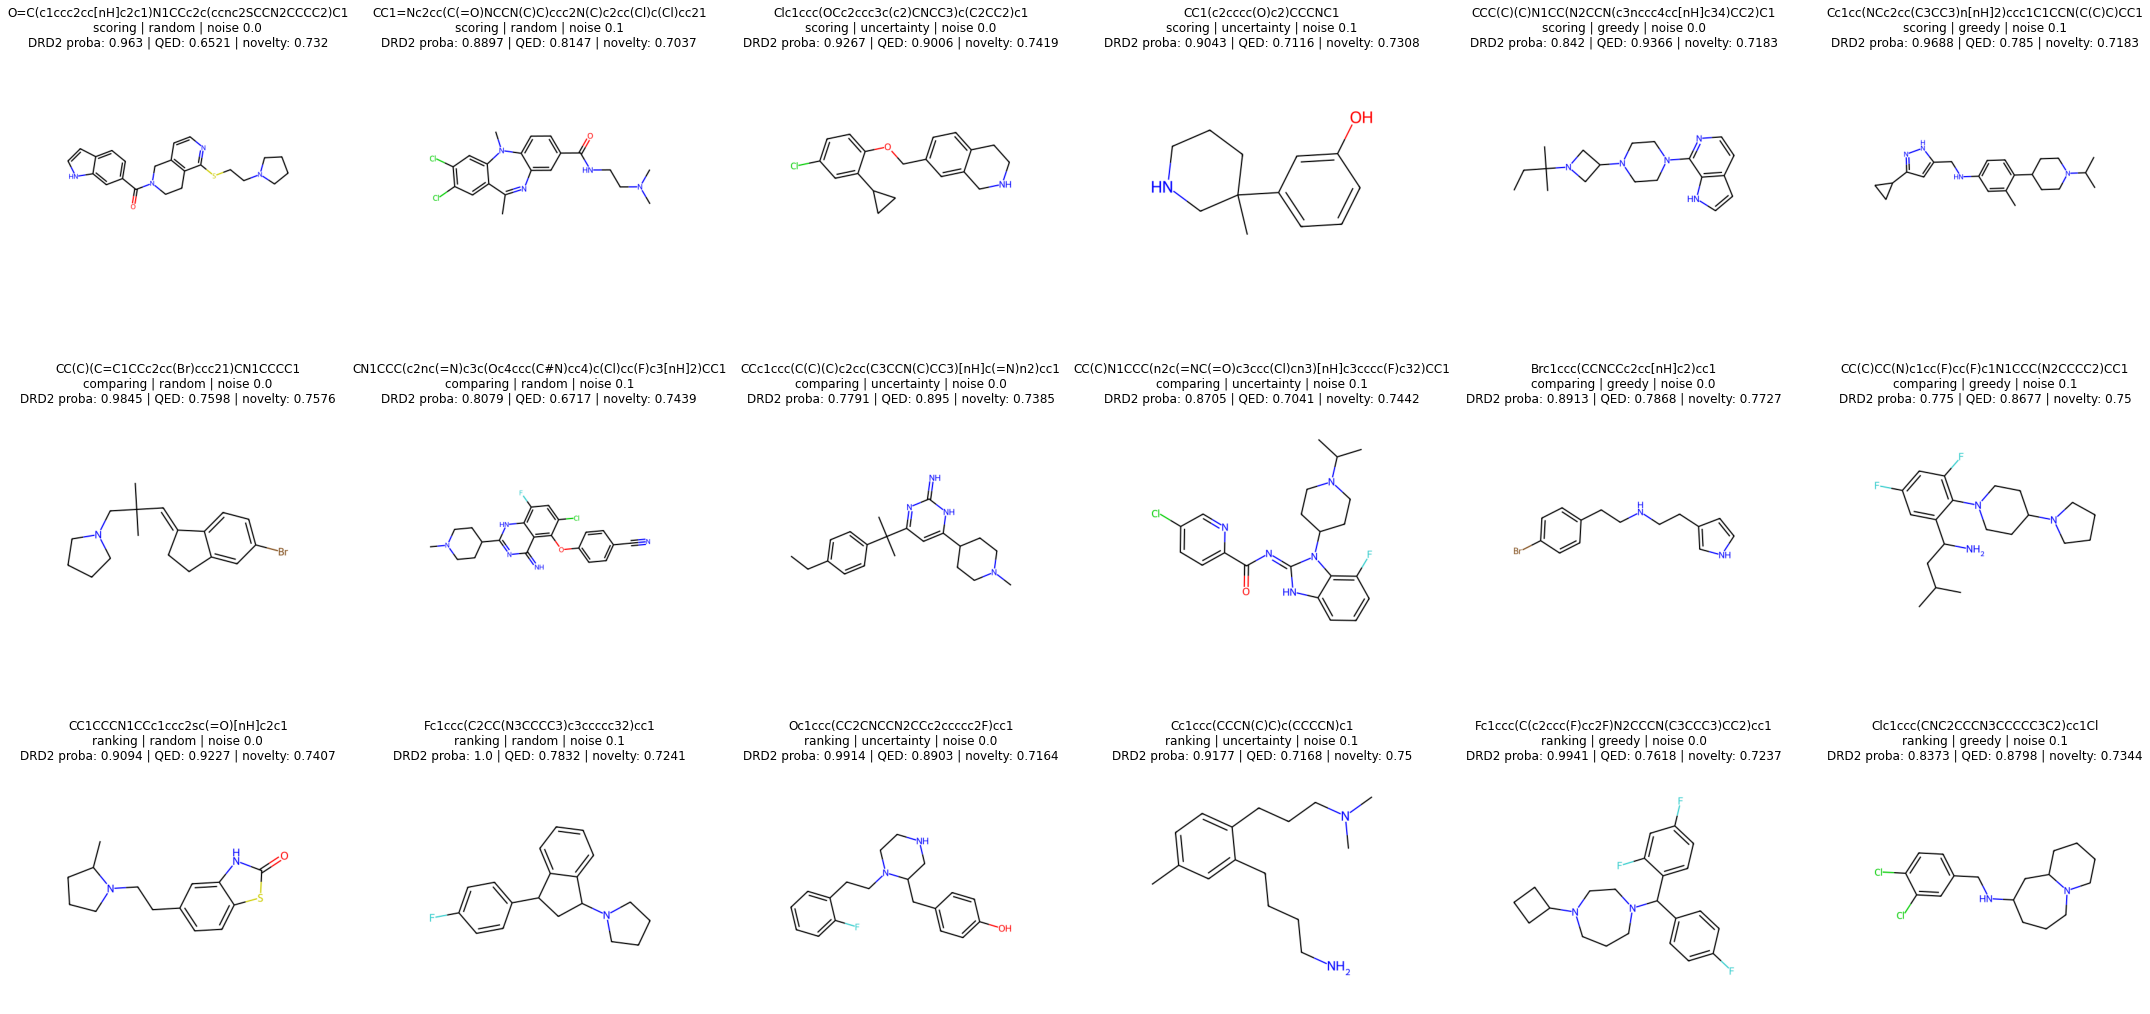

In [86]:
import os
import shutil
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D

# Assuming `filtered_models` and `model_names` are defined elsewhere in your code

# def draw_one_molecule(smile, legend_name):
#     mol = Chem.MolFromSmiles(smile)
#     # change legend name fontsize
#     img = Draw.MolToImage(mol, legend=legend_name, fitImage=False, size=(400,400), legendFontSize=100)
#     return img

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image
import io
import matplotlib.pyplot as plt

def draw_one_molecule(smile, legend_name):
    mol = Chem.MolFromSmiles(smile)
    d2d = rdMolDraw2D.MolDraw2DCairo(400, 400)
    dopts = d2d.drawOptions()
    dopts.legendFontSize = 100  # Set the desired font size
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    img = d2d.GetDrawingText()
    img = Image.open(io.BytesIO(img))
    return img

fig, ax = plt.subplots(3, 6, figsize=(30, 15))
ax = ax.flatten()
index = 0

model_names_mapping = {
    "score_regression": "scoring",
    "bradley_terry": "comparing",
    "rank_listnet": "ranking"
}

for model_name in model_names:
    for acquisition in ["random", "uncertainty", "greedy"]:
        for sigma_noise in [0.0, 0.1]:
            # Create the figure and axes once for each acquisition and noise combination
            
            REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
            smiles_list = filtered_combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["smiles_list"]
            drd2_probas = filtered_combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["drd2_proba"]
            qed_scores = filtered_combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["qed_score"]
            novelty_scores = filtered_combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["novelty_score"]
            
            # Then we sort them by novelty score
            sorted_indices = sorted(range(len(novelty_scores)), key=lambda i: novelty_scores[i], reverse=True)[:3]
            # Then we sort them by qed score
            sorted_indices = sorted(sorted_indices, key=lambda i: qed_scores[i], reverse=True)[:2]
            # We will sort by DRD2 probability
            sorted_indices = sorted(sorted_indices, key=lambda i: drd2_probas[i], reverse=True)
            
            
            max_index = sorted_indices[0]
            smile = smiles_list[max_index]
            props = {prop: filtered_combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"][prop][max_index] for prop in [
                "drd2_proba", "novelty_score", "sa_score", "qed_score", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"]}
            drd2_proba = props["drd2_proba"]
            qed_score = props["qed_score"]
            novelty_score = props["novelty_score"]
            legend_name = f"{smile}\n{model_names_mapping[model_name]} | {acquisition} | noise {sigma_noise}\nDRD2 proba: {round(drd2_proba, 4)} | QED: {round(qed_score, 4)} | novelty: {round(novelty_score, 4)}"
            img = draw_one_molecule(smile, legend_name)
            ax[index].imshow(img)
            ax[index].set_title(legend_name, fontsize=12)
            ax[index].axis('off')
            index += 1
     
plt.tight_layout()
plt.show()

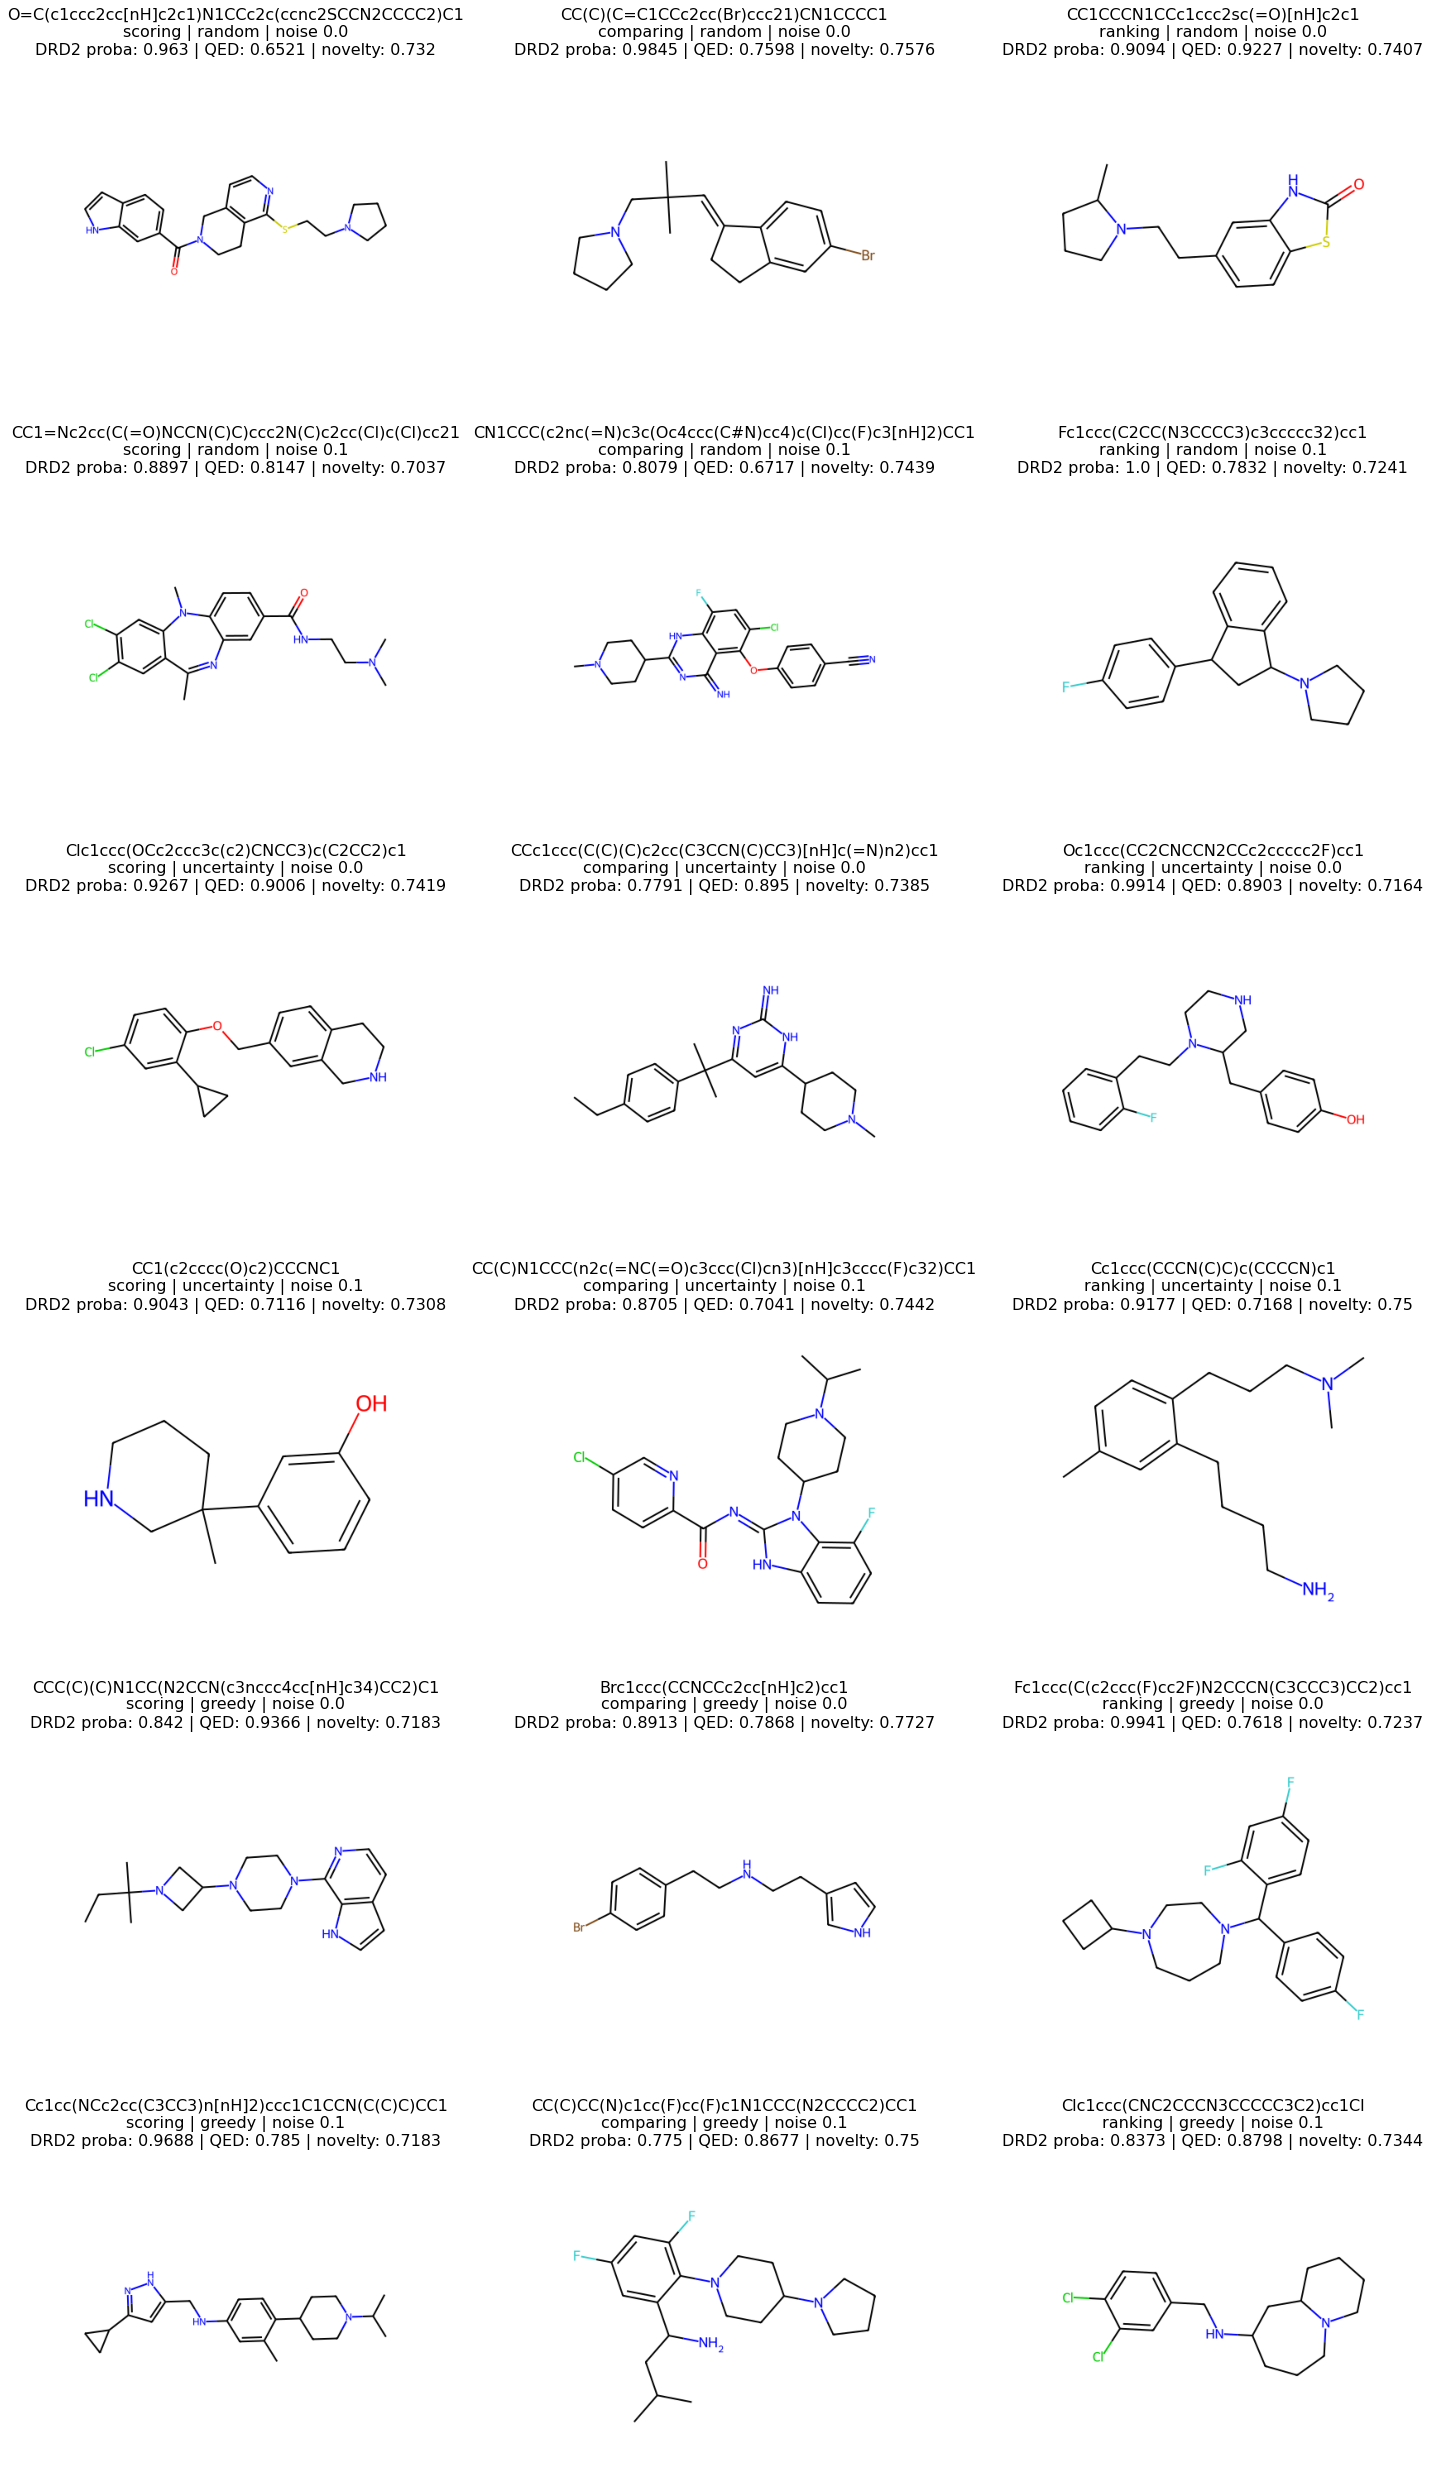

In [90]:
import os
import shutil
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D

# Assuming `filtered_models` and `model_names` are defined elsewhere in your code

# def draw_one_molecule(smile, legend_name):
#     mol = Chem.MolFromSmiles(smile)
#     # change legend name fontsize
#     img = Draw.MolToImage(mol, legend=legend_name, fitImage=False, size=(400,400), legendFontSize=100)
#     return img

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image
import io
import matplotlib.pyplot as plt

def draw_one_molecule(smile, legend_name):
    mol = Chem.MolFromSmiles(smile)
    d2d = rdMolDraw2D.MolDraw2DCairo(400, 400)
    dopts = d2d.drawOptions()
    dopts.legendFontSize = 100  # Set the desired font size
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    img = d2d.GetDrawingText()
    img = Image.open(io.BytesIO(img))
    return img

fig, ax = plt.subplots(6, 3, figsize=(20, 35))
ax = ax.flatten()
index = 0

model_names_mapping = {
    "score_regression": "scoring",
    "bradley_terry": "comparing",
    "rank_listnet": "ranking"
}

for acquisition in ["random", "uncertainty", "greedy"]:
    for sigma_noise in [0.0, 0.1]:
        for model_name in model_names:
            # Create the figure and axes once for each acquisition and noise combination

            smiles_list = filtered_combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["smiles_list"]
            drd2_probas = filtered_combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["drd2_proba"]
            qed_scores = filtered_combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["qed_score"]
            novelty_scores = filtered_combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["novelty_score"]
            
            # Then we sort them by novelty score
            sorted_indices = sorted(range(len(novelty_scores)), key=lambda i: novelty_scores[i], reverse=True)[:3]
            # Then we sort them by qed score
            sorted_indices = sorted(sorted_indices, key=lambda i: qed_scores[i], reverse=True)[:2]
            # We will sort by DRD2 probability
            sorted_indices = sorted(sorted_indices, key=lambda i: drd2_probas[i], reverse=True)
            
            
            max_index = sorted_indices[0]
            smile = smiles_list[max_index]
            props = {prop: filtered_combined_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"][prop][max_index] for prop in [
                "drd2_proba", "novelty_score", "sa_score", "qed_score", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"]}
            drd2_proba = props["drd2_proba"]
            qed_score = props["qed_score"]
            novelty_score = props["novelty_score"]
            legend_name = f"{smile}\n{model_names_mapping[model_name]} | {acquisition} | noise {sigma_noise}\nDRD2 proba: {round(drd2_proba, 4)} | QED: {round(qed_score, 4)} | novelty: {round(novelty_score, 4)}"
            img = draw_one_molecule(smile, legend_name)
            ax[index].imshow(img)
            ax[index].set_title(legend_name, fontsize=16)
            ax[index].axis('off')
            index += 1
     
plt.tight_layout()
plt.show()


In [23]:
### Draw the smiles using RDKit for filtered molecules
from rdkit.Chem import Draw

def draw_one_molecules(smile):
    mol = Chem.MolFromSmiles(smile)
    img = Draw.MolToImage(mol, legend=smile, size=(300, 300))
    return img

# Note that if there are too many filtered smiles, this would run forever!
run_this_cell = False

if run_this_cell:
    for i, model_name in enumerate(model_names):
        if os.path.exists(f"smiles_figure_{model_name}"):
            shutil.rmtree(f"smiles_figure_{model_name}")
        os.mkdir(f"smiles_figure_{model_name}")
        for acquisition in ["random", "uncertainty", "greedy"]:
            for sigma_noise in [0.0, 0.1]:
                os.makedirs(f"smiles_figure_{model_name}_n_steps_100/acq_{acquisition}_noise_{sigma_noise}", exist_ok=True)
                for REINVENT_round in [4]:
                    os.makedirs(f"smiles_figure_{model_name}_n_steps_100/acq_{acquisition}_noise_{sigma_noise}/REINVENT_round_{REINVENT_round}", exist_ok=True)
                    
                    REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
                    smiles_list = filtered_models[model_name][f"acq_{acquisition}_noise_{sigma_noise}"]["smiles_list"][REINVENT_round_name]
                    for i, smile in enumerate(smiles_list):
                        img = draw_one_molecules(smile)
                        img.save(f"smiles_figure_{model_name}_n_steps_100/acq_{acquisition}_noise_{sigma_noise}/REINVENT_round_{REINVENT_round}/molecule_{i+1}.png")



### Benchmark 1: Model performance on predicting DRD2 activity using ROC-AUC score
### 

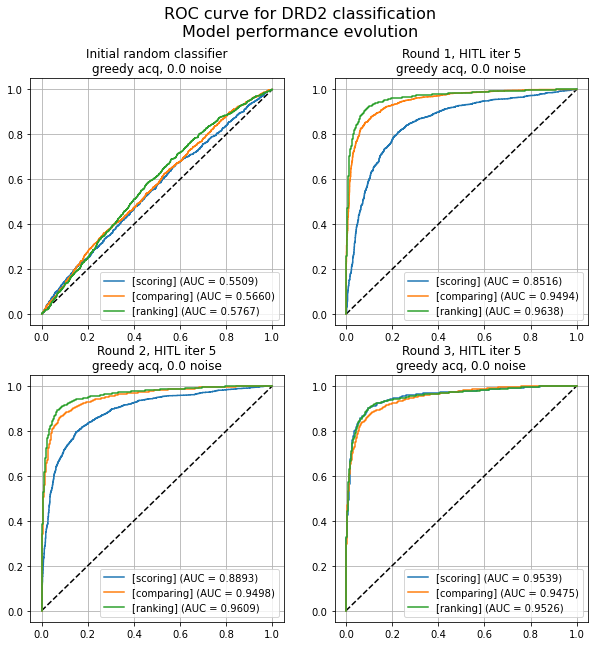

In [91]:
# Plotting 2 x 3 grid
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# flatten ax
ax = ax.flatten()


# subplot title
fig.suptitle(f"ROC curve for DRD2 classification\nModel performance evolution", fontsize=16)

index = 0
for sigma_noise in [0.0]:
    for acquisition in ["greedy"]:
        for REINVENT_round in [1,2,3,4]:
            REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
            
            fpr_scoring = models["score_regression"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['fpr']
            tpr_scoring = models["score_regression"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['tpr']
            roc_auc_scoring = models["score_regression"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['roc_auc']

            fpr_comparing = models["bradley_terry"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['fpr']
            tpr_comparing = models["bradley_terry"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['tpr']
            roc_auc_comparing = models["bradley_terry"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['roc_auc']

            fpr_ranking = models["rank_listnet"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['fpr']
            tpr_ranking = models["rank_listnet"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['tpr']
            roc_auc_ranking = models["rank_listnet"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['roc_auc']

            # Draw a diagonal line
            ax[index].plot([0, 1], [0, 1], 'k--')
            ax[index].plot(fpr_scoring, tpr_scoring, label=f"[scoring] (AUC = {roc_auc_scoring:.4f})")
            ax[index].plot(fpr_comparing, tpr_comparing, label=f"[comparing] (AUC = {roc_auc_comparing:.4f})")
            ax[index].plot(fpr_ranking, tpr_ranking, label=f"[ranking] (AUC = {roc_auc_ranking:.4f})")
            
            # turn on grid for each subplot
            ax[index].grid()
            if REINVENT_round == 1:
                ax[index].set_title(f"Initial random classifier\n{acquisition} acq, {sigma_noise} noise")
            else:
                ax[index].set_title(f"Round {REINVENT_round - 1}, HITL iter 5\n{acquisition} acq, {sigma_noise} noise")
            ax[index].legend(loc='lower right')
        
            index += 1


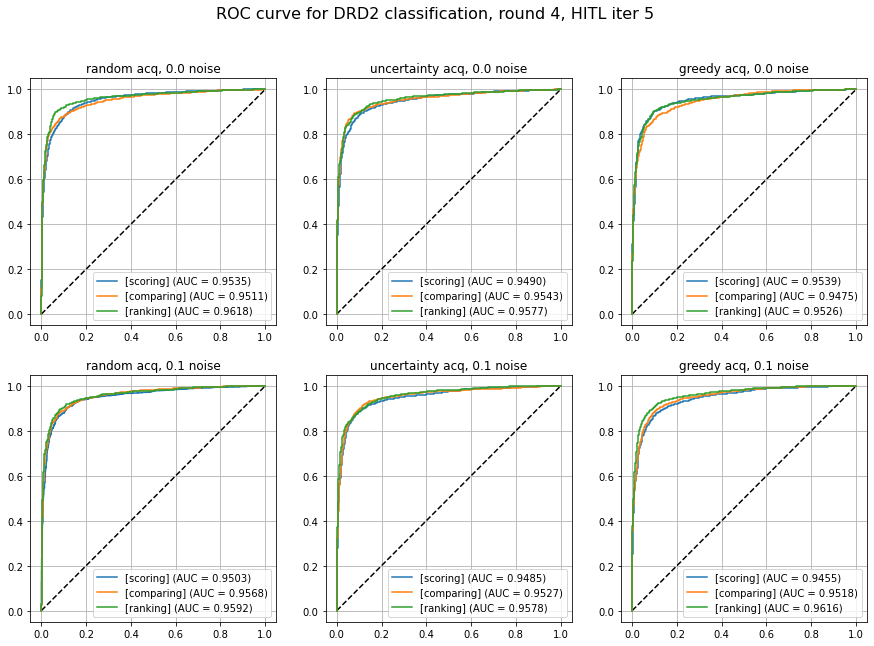

In [25]:
# Plotting 2 x 3 grid
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# flatten ax
ax = ax.flatten()

REINVENT_round = 4
# subplot title
fig.suptitle(f"ROC curve for DRD2 classification, round {REINVENT_round}, HITL iter 5", fontsize=16)

index = 0
for sigma_noise in [0.0, 0.1]:
    for acquisition in ["random", "uncertainty", "greedy"]:
        REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
        
        fpr_scoring = models["score_regression"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['fpr']
        tpr_scoring = models["score_regression"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['tpr']
        roc_auc_scoring = models["score_regression"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['roc_auc']

        fpr_comparing = models["bradley_terry"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['fpr']
        tpr_comparing = models["bradley_terry"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['tpr']
        roc_auc_comparing = models["bradley_terry"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['roc_auc']

        fpr_ranking = models["rank_listnet"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['fpr']
        tpr_ranking = models["rank_listnet"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['tpr']
        roc_auc_ranking = models["rank_listnet"][f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['roc_auc']

        # Draw a diagonal line
        ax[index].plot([0, 1], [0, 1], 'k--')
        ax[index].plot(fpr_scoring, tpr_scoring, label=f"[scoring] (AUC = {roc_auc_scoring:.4f})")
        ax[index].plot(fpr_comparing, tpr_comparing, label=f"[comparing] (AUC = {roc_auc_comparing:.4f})")
        ax[index].plot(fpr_ranking, tpr_ranking, label=f"[ranking] (AUC = {roc_auc_ranking:.4f})")
        
        # turn on grid for each subplot
        ax[index].grid()
        ax[index].set_title(f"{acquisition} acq, {sigma_noise} noise")
        ax[index].legend(loc='lower right')
        
        index += 1


### Benchmark 1: Model performance on predicting DRD2 activity using accuracy, precision, recall, F1, MCC score at 0.5 threshold
### 

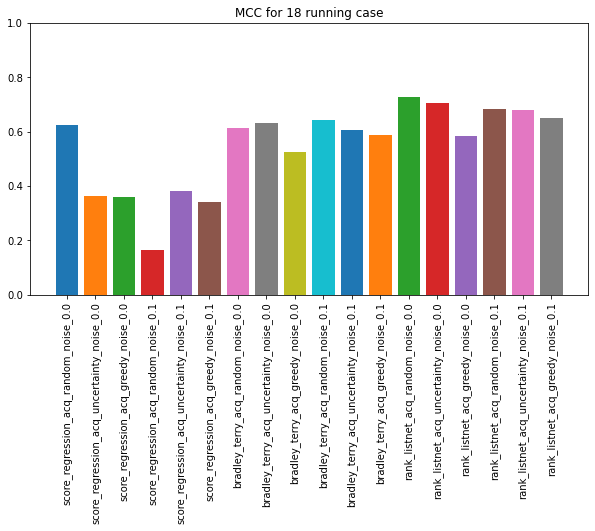

In [26]:
running_case = [
    ("score_regression", "acq_random_noise_0.0"),
    ("score_regression", "acq_uncertainty_noise_0.0"),
    ("score_regression", "acq_greedy_noise_0.0"),
    ("score_regression", "acq_random_noise_0.1"),
    ("score_regression", "acq_uncertainty_noise_0.1"),
    ("score_regression", "acq_greedy_noise_0.1"),
    ("bradley_terry", "acq_random_noise_0.0"),
    ("bradley_terry", "acq_uncertainty_noise_0.0"),
    ("bradley_terry", "acq_greedy_noise_0.0"),
    ("bradley_terry", "acq_random_noise_0.1"),
    ("bradley_terry", "acq_uncertainty_noise_0.1"),
    ("bradley_terry", "acq_greedy_noise_0.1"),
    ("rank_listnet", "acq_random_noise_0.0"),
    ("rank_listnet", "acq_uncertainty_noise_0.0"),
    ("rank_listnet", "acq_greedy_noise_0.0"),
    ("rank_listnet", "acq_random_noise_0.1"),
    ("rank_listnet", "acq_uncertainty_noise_0.1"),
    ("rank_listnet", "acq_greedy_noise_0.1")
]

# Plot accuracy at threshold 0.75 for 18 running case (bar plot)

metric_name = "MCC" # accuracy, precision, recall, f1, MCC
plt.figure(figsize=(10, 5))

for i, case in enumerate(running_case):
    REINVENT_round_name = "REINVENT_round_4"
    index_threshold = 50
    accuracy = models[case[0]][case[1]]["metrics"][REINVENT_round_name][metric_name]
    metric_value = models[case[0]][case[1]]["metrics"][REINVENT_round_name][metric_name][index_threshold]
    plt.bar(i, metric_value, label=f"{case[0]}_{case[1]}")
plt.xticks(range(len(running_case)), [f"{case[0]}_{case[1]}" for case in running_case], rotation=90)
plt.ylim([0.0, 1.0])
# draw a horizontal line at 0.5

plt.title(f"{metric_name} for 18 running case")
plt.show()

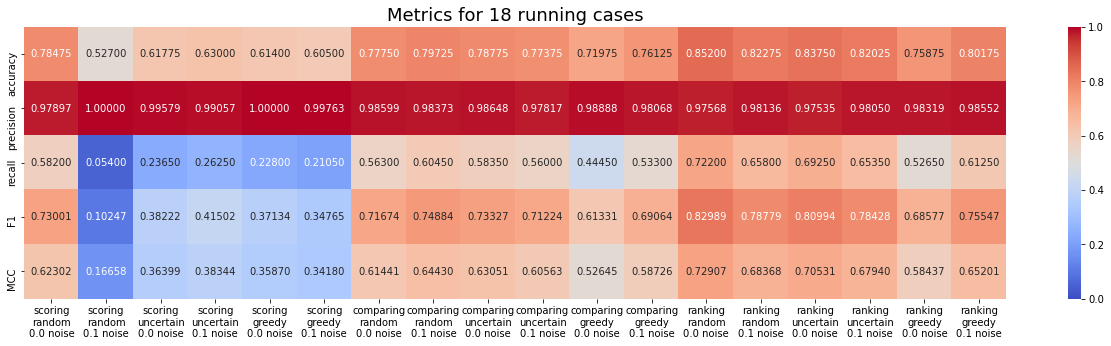

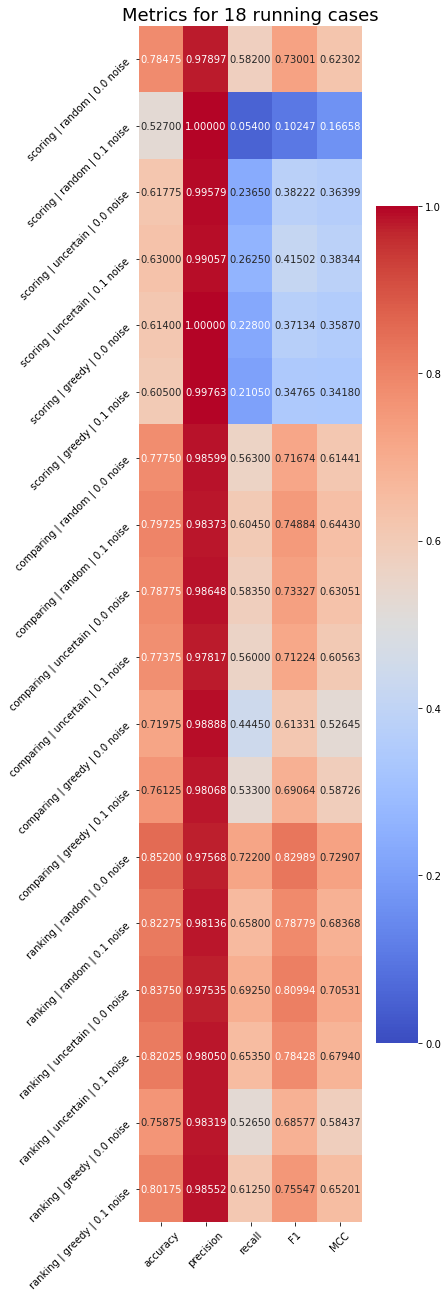

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

running_case = [
    ("score_regression", "acq_random", "noise_0.0"),
    ("score_regression", "acq_random", "noise_0.1"),
    ("score_regression", "acq_uncertainty", "noise_0.0"),
    ("score_regression", "acq_uncertainty", "noise_0.1"),
    ("score_regression", "acq_greedy", "noise_0.0"),
    ("score_regression", "acq_greedy", "noise_0.1"),
    ("bradley_terry", "acq_random", "noise_0.0"),
    ("bradley_terry", "acq_random", "noise_0.1"),
    ("bradley_terry", "acq_uncertainty", "noise_0.0"),
    ("bradley_terry", "acq_uncertainty", "noise_0.1"),
    ("bradley_terry", "acq_greedy", "noise_0.0"),
    ("bradley_terry", "acq_greedy", "noise_0.1"),
    ("rank_listnet", "acq_random", "noise_0.0"),
    ("rank_listnet", "acq_random", "noise_0.1"),
    ("rank_listnet", "acq_uncertainty", "noise_0.0"),
    ("rank_listnet", "acq_uncertainty", "noise_0.1"),
    ("rank_listnet", "acq_greedy", "noise_0.0"),
    ("rank_listnet", "acq_greedy", "noise_0.1")
]

model_name_map = {
    "score_regression": "scoring",
    "bradley_terry": "comparing",
    "rank_listnet": "ranking"
}

acq_name_map = {
    "acq_random": "random",
    "acq_uncertainty": "uncertain",
    "acq_greedy": "greedy"
}

noise_name_map = {
    "noise_0.0": "0.0 noise",
    "noise_0.1": "0.1 noise"
}
metrics = ["accuracy", "precision", "recall", "F1", "MCC"]
REINVENT_round_name = "REINVENT_round_4"
index_threshold = 50

# Initialize a matrix to store the metric values for the heatmap
heatmap_data = np.zeros((len(metrics), len(running_case)))

for i, metric_name in enumerate(metrics):
    for j, case in enumerate(running_case):
        metric_value = models[case[0]][f"{case[1]}_{case[2]}"]["metrics"][REINVENT_round_name][metric_name][index_threshold]
        heatmap_data[i, j] = metric_value

plt.figure(figsize=(22, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".5f", cmap="coolwarm", 
            xticklabels=[f"{model_name_map[case[0]]}\n{acq_name_map[case[1]]}\n{noise_name_map[case[2]]}" for case in running_case],
            yticklabels=metrics,
            # set color bar to range 0 and 1
            vmin=0.0, vmax=1.0)

plt.xticks(rotation=0)
plt.title("Metrics for 18 running cases", fontsize=18)
plt.show()

# Now we plot the exact same but transpose table

plt.figure(figsize=(5, 22))
sns.heatmap(heatmap_data.T, annot=True, fmt=".5f", cmap="coolwarm", 
            xticklabels=metrics,
            yticklabels=[f"{model_name_map[case[0]]} | {acq_name_map[case[1]]} | {noise_name_map[case[2]]}" for case in running_case],
            # set color bar to range 0 and 1
            vmin=0.0, vmax=1.0)

plt.xticks(rotation=45)
plt.yticks(rotation=90)
plt.title("Metrics for 18 running cases", fontsize=18)
plt.show()

### Benchmark 2 and 3: DRD2 proba and ADME properties of molecules generated by REINVENT

PK parameters play a crucial role in understanding how a drug interacts with the body during drug development. These parameters provide insights into various aspects (ADME):

- Absorption: How the drug is absorbed after administration.
- Distribution: How the drug spreads across different bodily compartments or tissues.
- Metabolism: How the body processes or degrades the drug.
- Excretion: How the body eliminates or gets rid of the drug.


The logP parameter, or the partition coefficient, is a crucial molecular descriptor in medicinal chemistry and drug design. It quantifies the lipophilicity of chemical compounds and influences their pharmacokinetic properties

| LogP | Value Range | Characteristics | 
| --- | --- | --- |
| \< 1 | Too hydrophilic | Poor absorption, rapid excretion |
| 1 - 3 | Balanced hydrophilic and hydrophobic | Good absorption and bioavailability |
| 3 - 5 | Moderately hydrophobic | Potential absorption issues, consider formulation |
| \> 5 | Too hydrophobic | Poor solubility, potential toxicity, poor absorption |



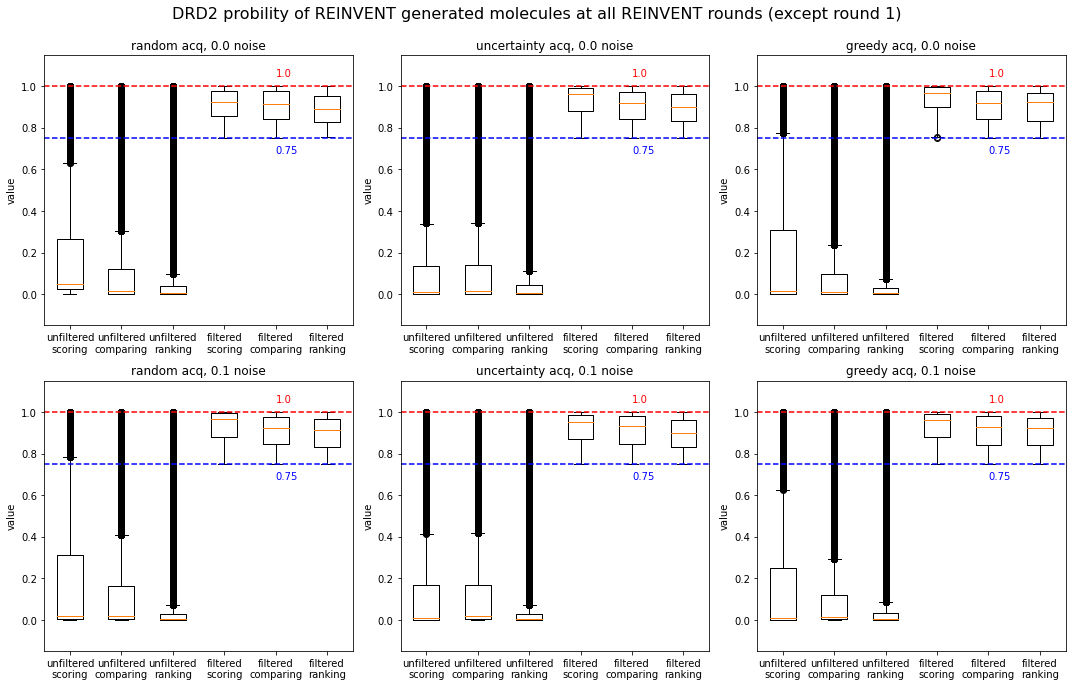

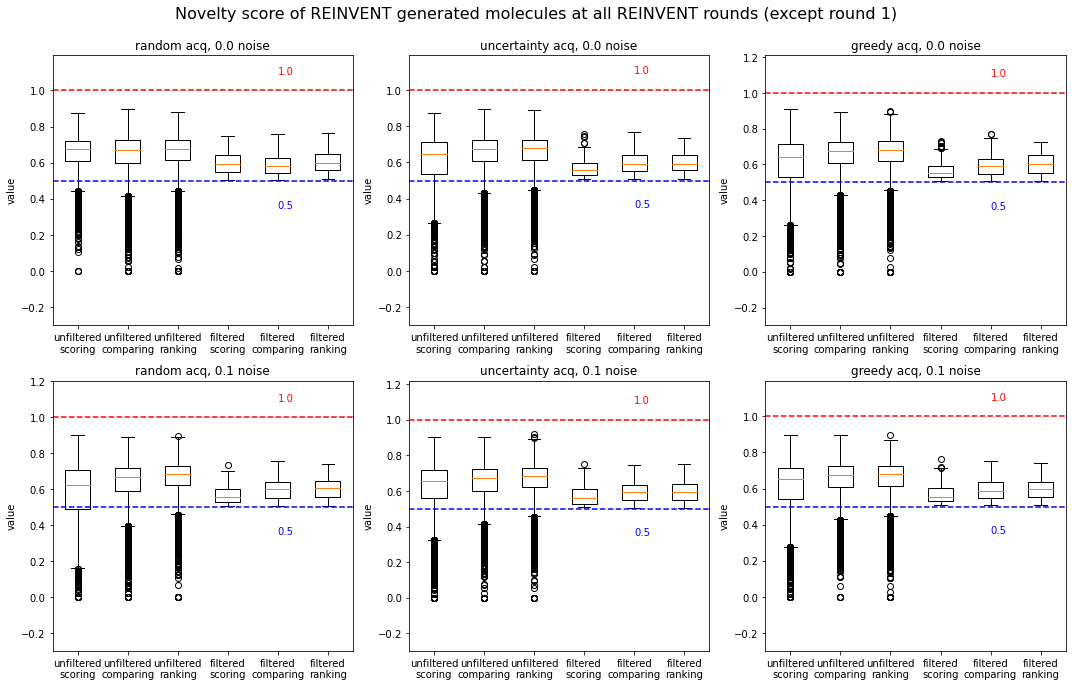

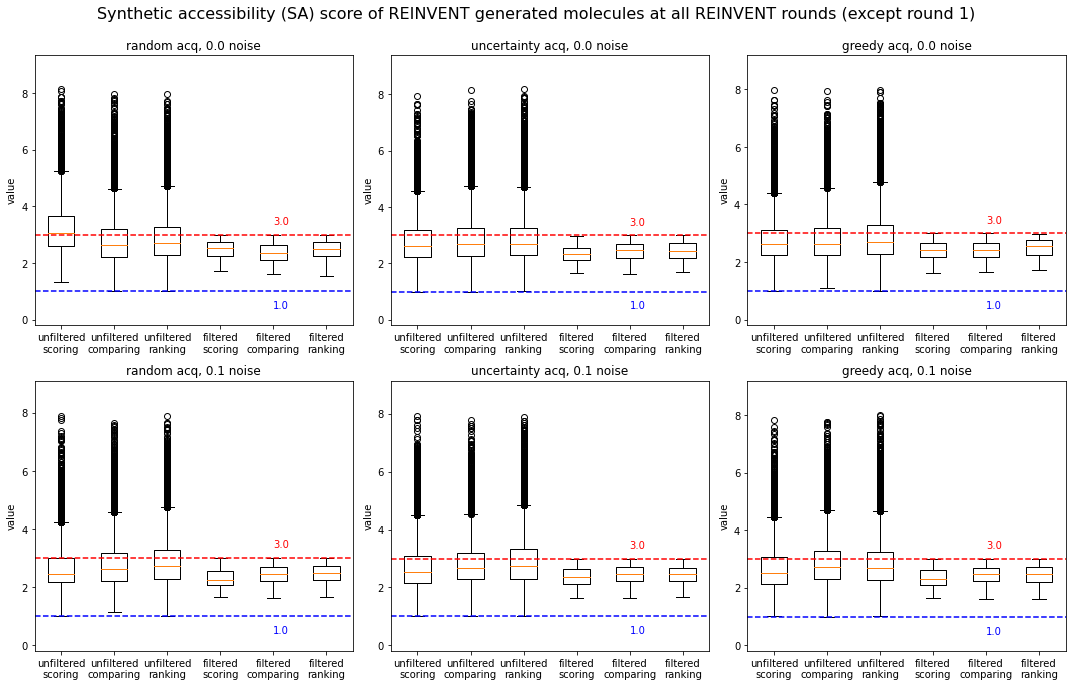

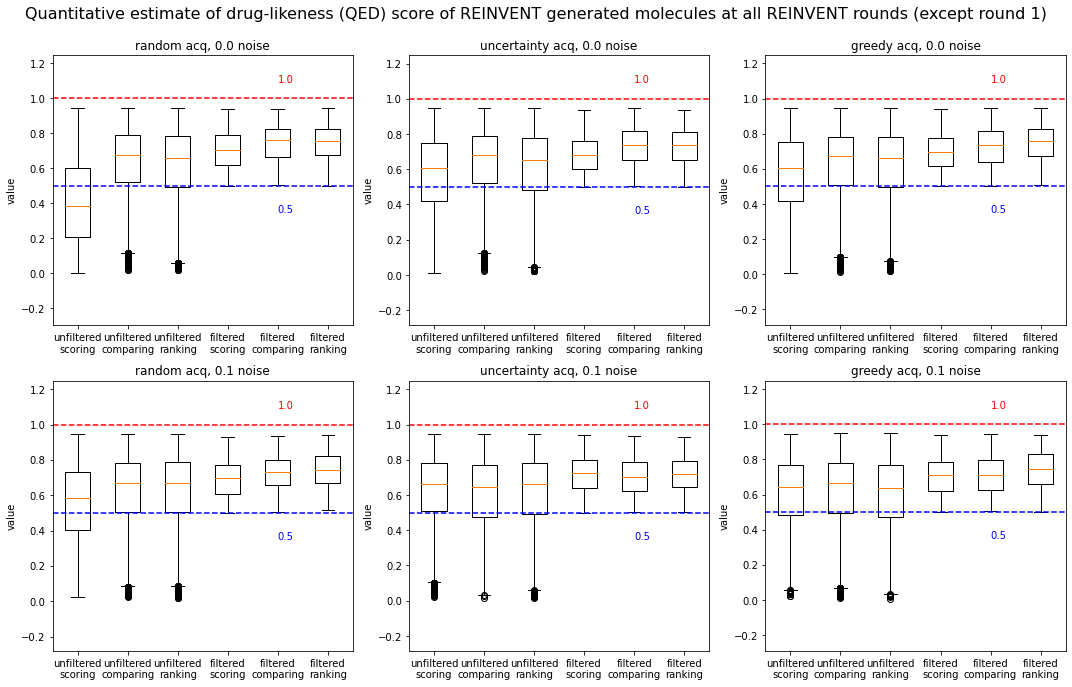

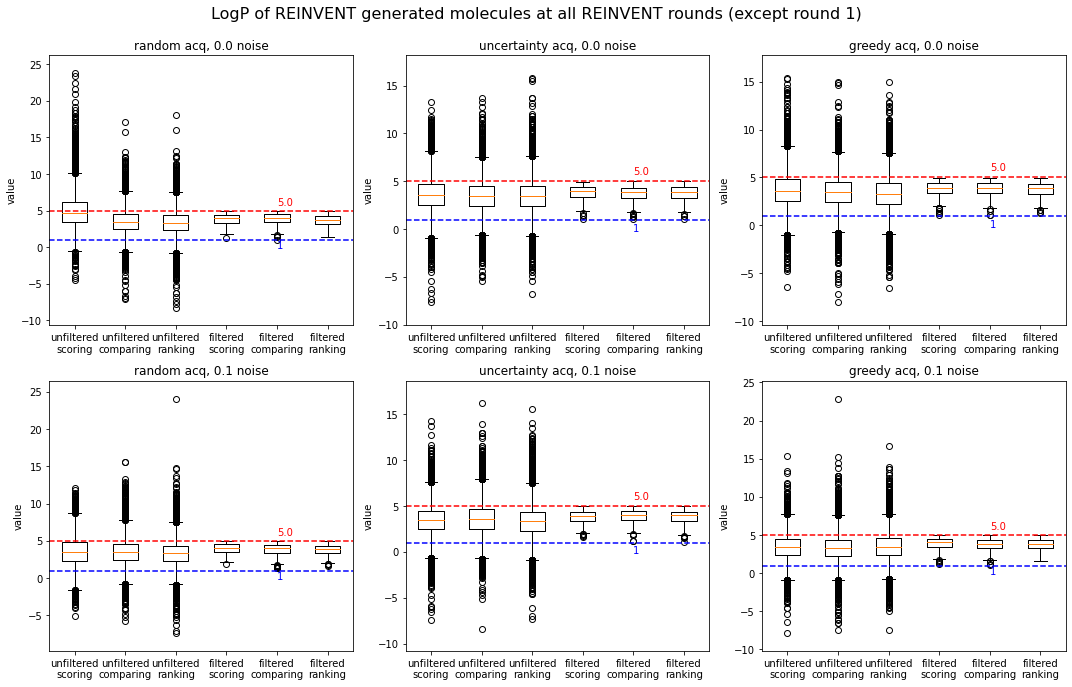

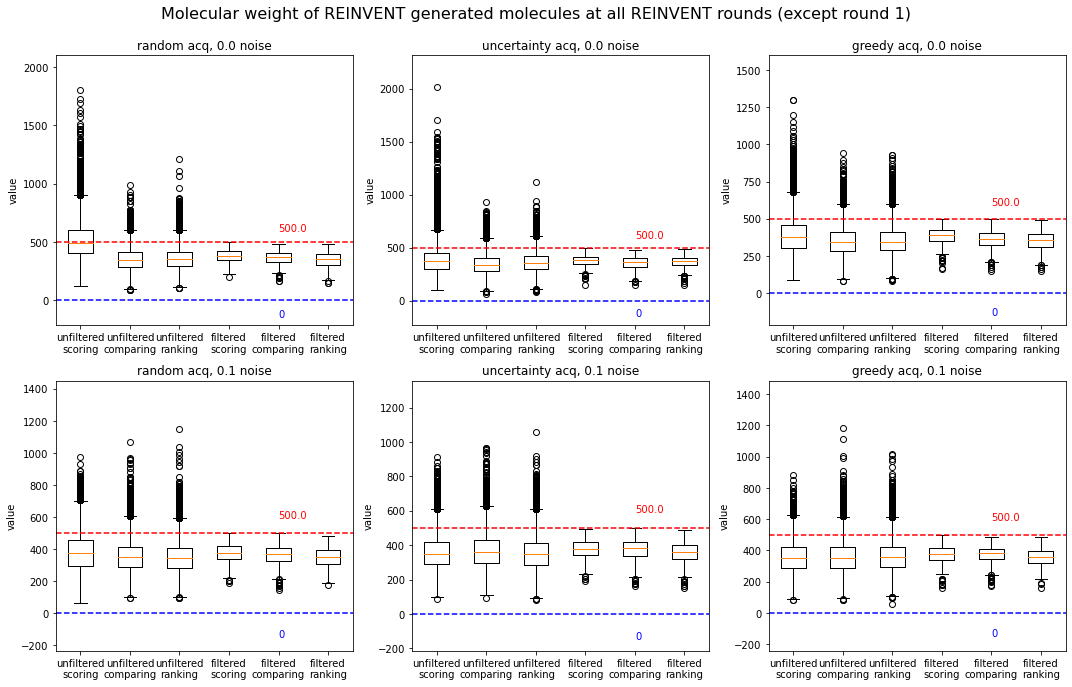

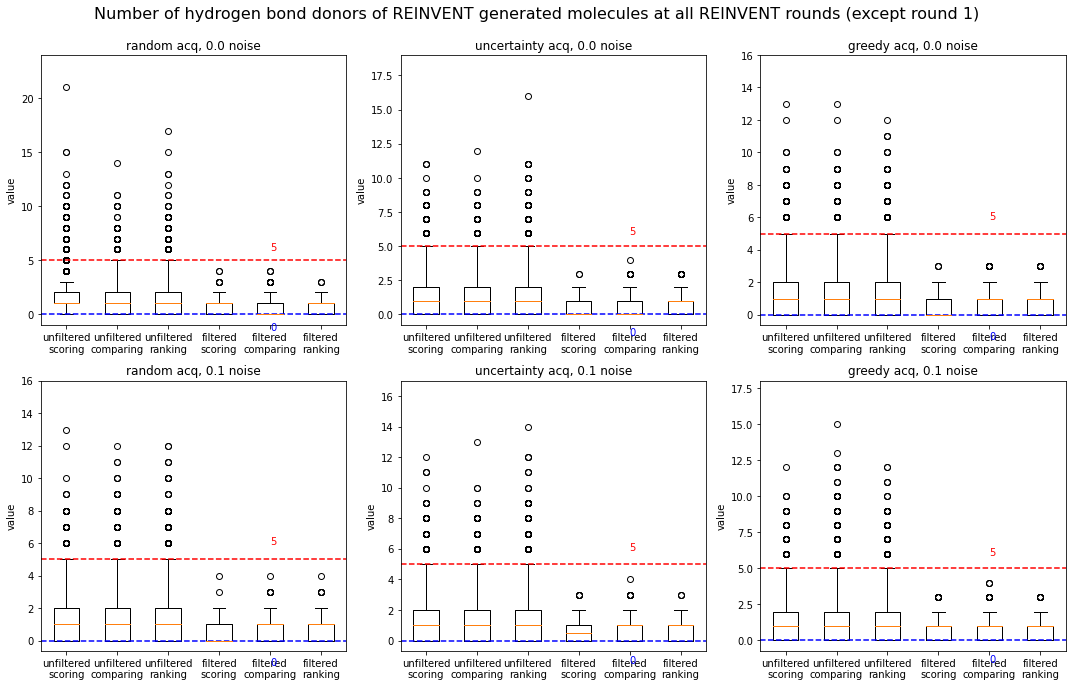

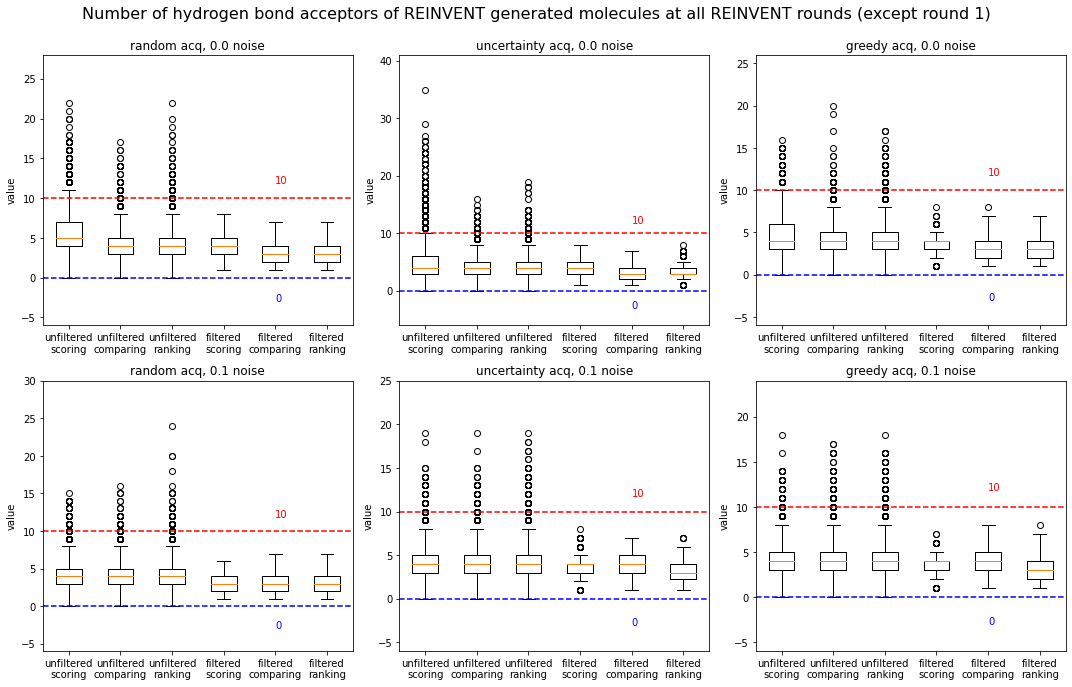

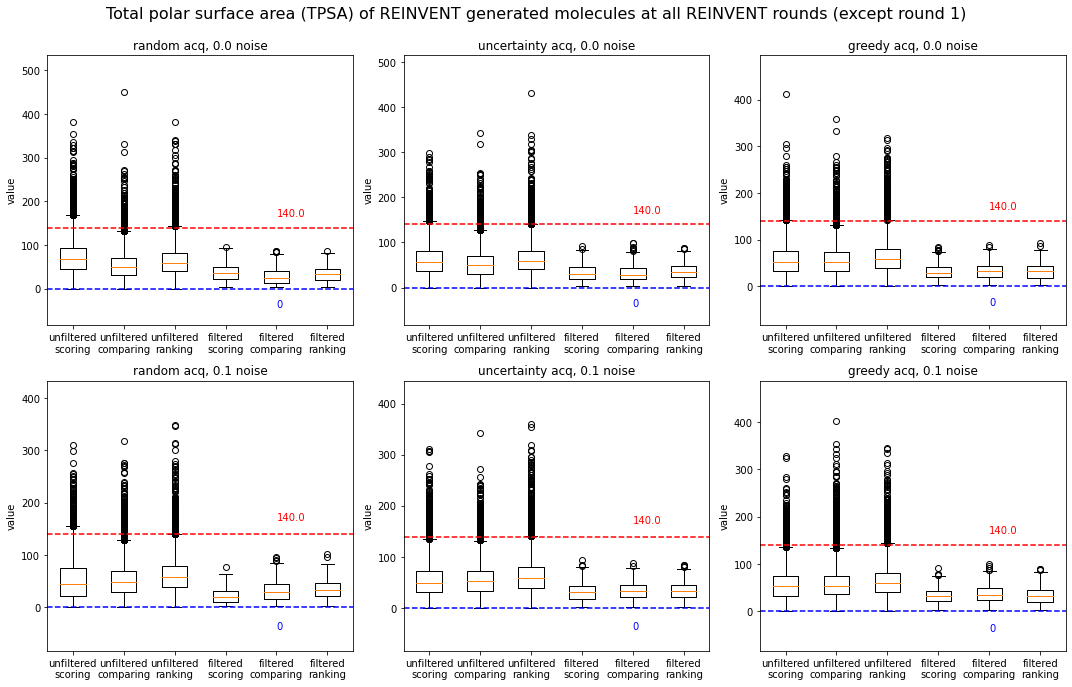

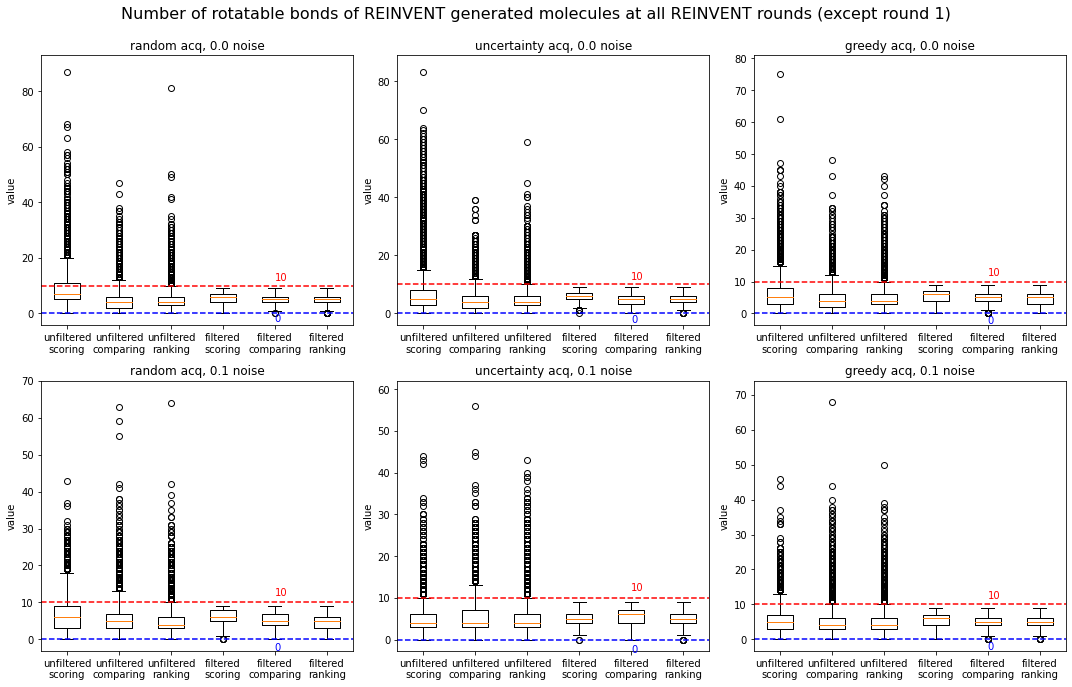

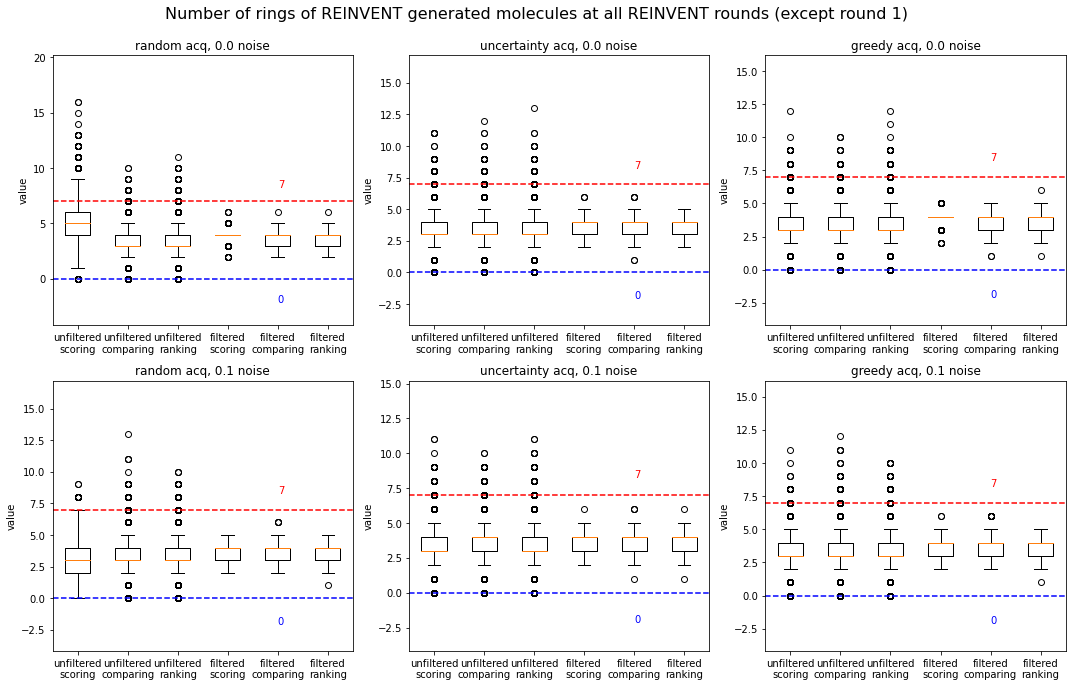

In [39]:
prop_names = ["drd2_proba", "novelty_score", "sa_score", "qed_score", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"]

lower_bounds = {
    "drd2_proba": 0.75,  # No lower limit, set to your preference
    "novelty_score": 0.5,  # No lower limit, set to your preference
    "sa_score": 1.0,  # Lower is better, minimum achievable is 1
    "qed_score": 0.5,  # Minimum acceptable QED score
    "logP": 1,  # No practical lower limit, but logP can be negative
    "mol_weight": 0,  # Molecules can technically weigh very little
    "h_donors": 0,  # Hydrogen bond donors can be zero
    "h_acceptors": 0,  # Hydrogen bond acceptors can be zero
    "tpsa": 0,  # Total polar surface area can be zero
    "rotatable_bonds": 0,  # Rotatable bonds can be zero
    "num_rings": 0  # Number of rings can be zero
}

upper_bounds = {
    "drd2_proba": 1.0,  # Maximum for a probability score
    "novelty_score": 1.0,  # Theoretical maximum for novelty score
    "sa_score": 3.0,  # Upper limit often considered for synthetic accessibility
    "qed_score": 1.0,  # Maximum possible QED score
    "logP": 5.0,  # Lipinski's rule of five
    "mol_weight": 500.0,  # Lipinski's rule of five
    "h_donors": 5,  # Lipinski's rule of five
    "h_acceptors": 10,  # Lipinski's rule of five
    "tpsa": 140.0,  # Veber's rule
    "rotatable_bonds": 10,  # Veber's rule
    "num_rings": 7  # Muegge’s rule
}

prop_name_mapping = {
    "drd2_proba": "DRD2 probility",
    "novelty_score": "Novelty score",
    "sa_score": "Synthetic accessibility (SA) score",
    "qed_score": "Quantitative estimate of drug-likeness (QED) score",
    "logP": "LogP",
    "mol_weight": "Molecular weight",
    "h_donors": "Number of hydrogen bond donors",
    "h_acceptors":  "Number of hydrogen bond acceptors",
    "tpsa": "Total polar surface area (TPSA)",
    "rotatable_bonds": "Number of rotatable bonds",
    "num_rings": "Number of rings"
}


for prop_name in prop_names:

    fig, ax = plt.subplots(2, 3, figsize=(15, 10))

    # Flatten ax
    ax = ax.flatten()

    # Subplot title
    fig.suptitle(f"{prop_name_mapping[prop_name]} of REINVENT generated molecules at all REINVENT rounds (except round 1)", fontsize=16)

    index = 0
    for sigma_noise in [0.0, 0.1]:
        for acquisition in ["random", "uncertainty", "greedy"]:
            unfiltered_prop_scoring = combined_models["score_regression"][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name]
            unfiltered_prop_comparing = combined_models["bradley_terry"][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name]
            unfiltered_prop_ranking = combined_models["rank_listnet"][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name]

            filtered_prop_scoring = filtered_combined_models["score_regression"][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name]
            filtered_prop_comparing = filtered_combined_models["bradley_terry"][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name]
            filtered_prop_ranking = filtered_combined_models["rank_listnet"][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name]

            # Creating a box plot
            ax[index].boxplot([unfiltered_prop_scoring, unfiltered_prop_comparing, unfiltered_prop_ranking,
                               filtered_prop_scoring, filtered_prop_comparing, filtered_prop_ranking,
                               ], 
                              labels=['unfiltered\nscoring', 'unfiltered\ncomparing', 'unfiltered\nranking',
                                        'filtered\nscoring', 'filtered\ncomparing', 'filtered\nranking'])

            # Turn on grid for each subplot
            #ax[index].grid()
            range_lim = (upper_bounds[prop_name] - lower_bounds[prop_name]) * 0.6
            # set only the top limit if only max(unfiltered) > max(filtered)
            if max(max(unfiltered_prop_scoring), max(unfiltered_prop_comparing), max(unfiltered_prop_ranking)) > max(max(filtered_prop_scoring), max(filtered_prop_comparing), max(filtered_prop_ranking)):
                ax[index].set_ylim(top=max(max(unfiltered_prop_scoring), max(unfiltered_prop_comparing), max(unfiltered_prop_ranking)) + range_lim)
            
            # set only the bottom limit if only min(unfiltered) < min(filtered)
            if min(min(unfiltered_prop_scoring), min(unfiltered_prop_comparing), min(unfiltered_prop_ranking)) < min(min(filtered_prop_scoring), min(filtered_prop_comparing), min(filtered_prop_ranking)):
                ax[index].set_ylim(bottom=min(min(unfiltered_prop_scoring), min(unfiltered_prop_comparing), min(unfiltered_prop_ranking)) - range_lim)

                        

            # Draw lower bound with blue color
            ax[index].axhline(y=lower_bounds[prop_name], color='b', linestyle='--')
            # Annotate the lower bound value
            ax[index].text(5, lower_bounds[prop_name] - range_lim * 0.5, f"{lower_bounds[prop_name]}", color='b')

            # Draw upper bound with red color
            ax[index].axhline(y=upper_bounds[prop_name], color='r', linestyle='--')
            # Annotate the upper bound value
            ax[index].text(5, upper_bounds[prop_name] + range_lim * 0.3, f"{upper_bounds[prop_name]}", color='r')

            ax[index].set_title(f"{acquisition} acq, {sigma_noise} noise")
            ax[index].set_ylabel("value")
            
            index += 1

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

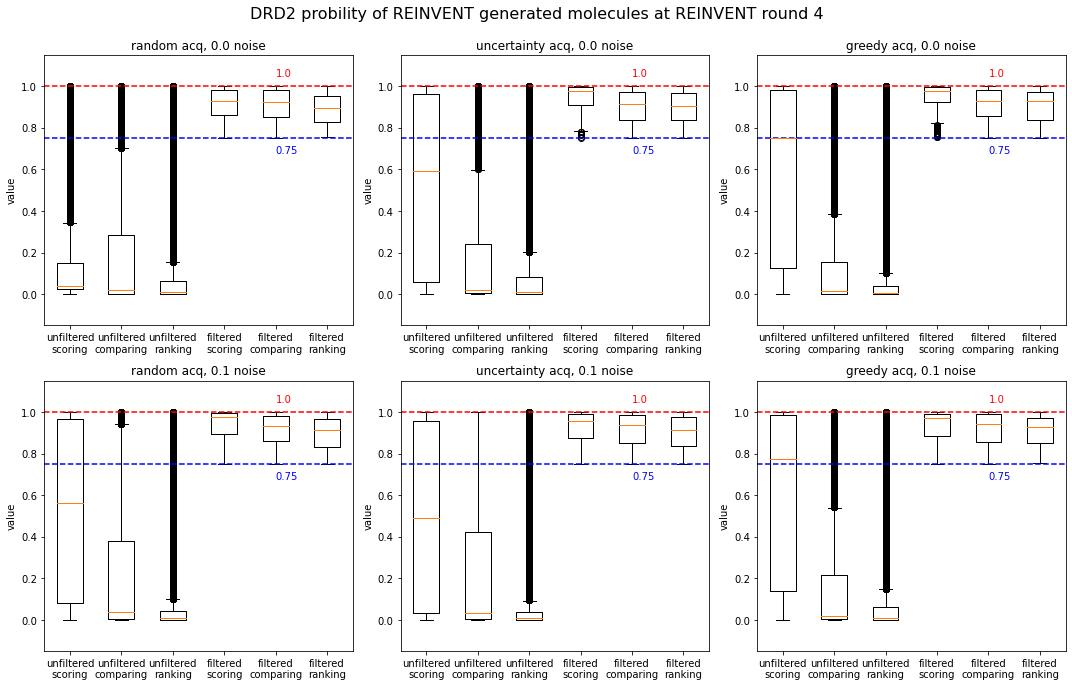

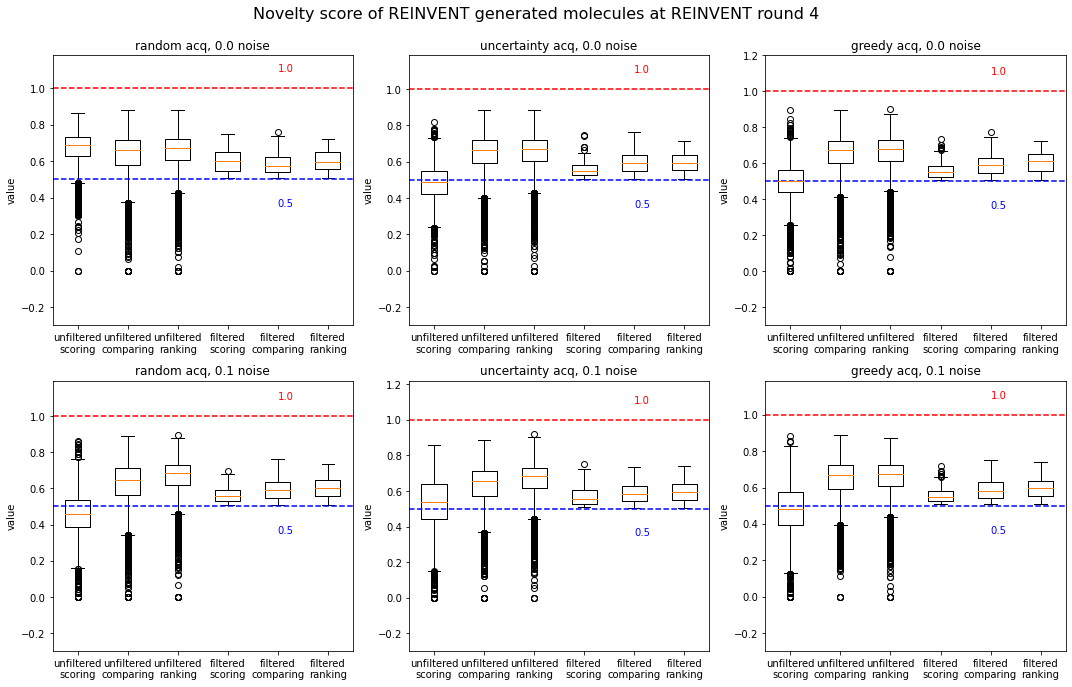

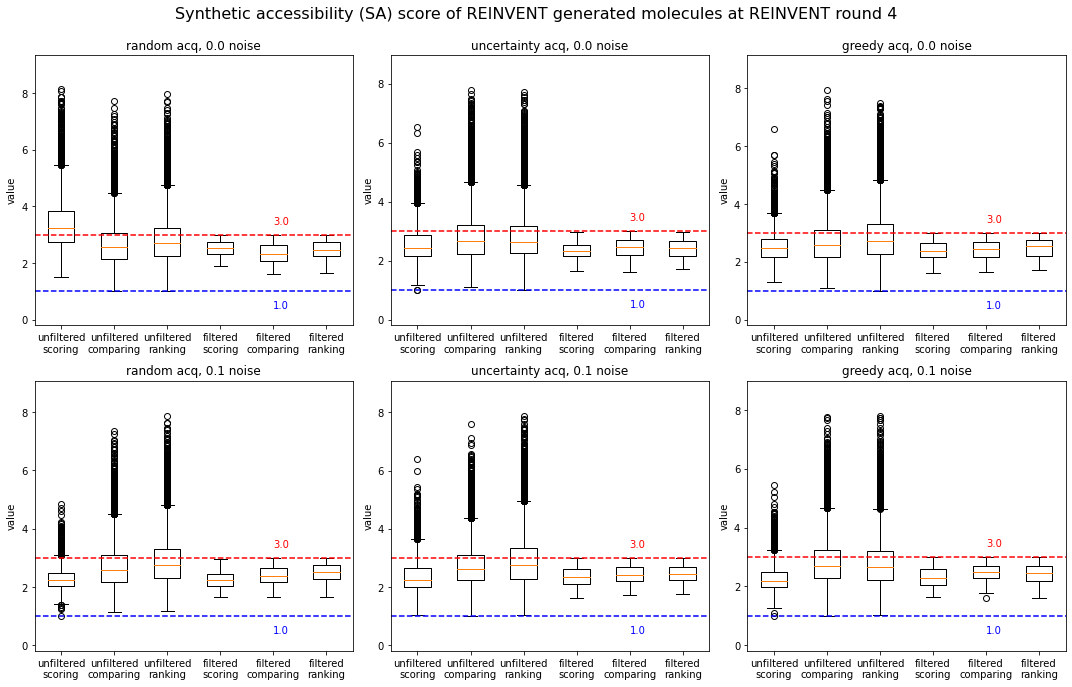

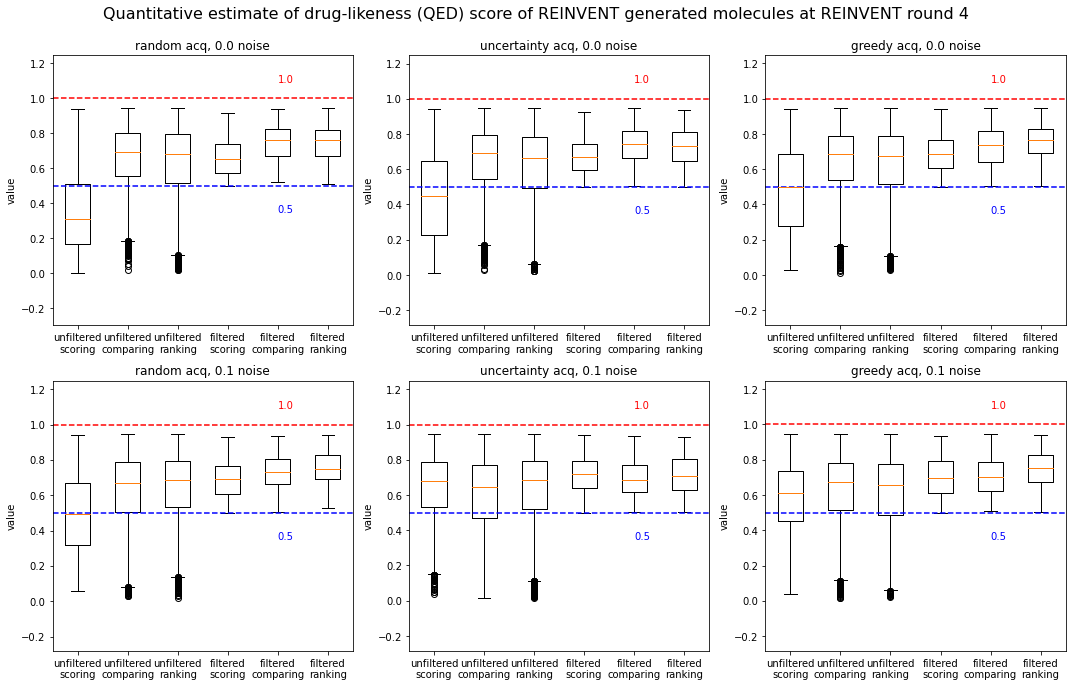

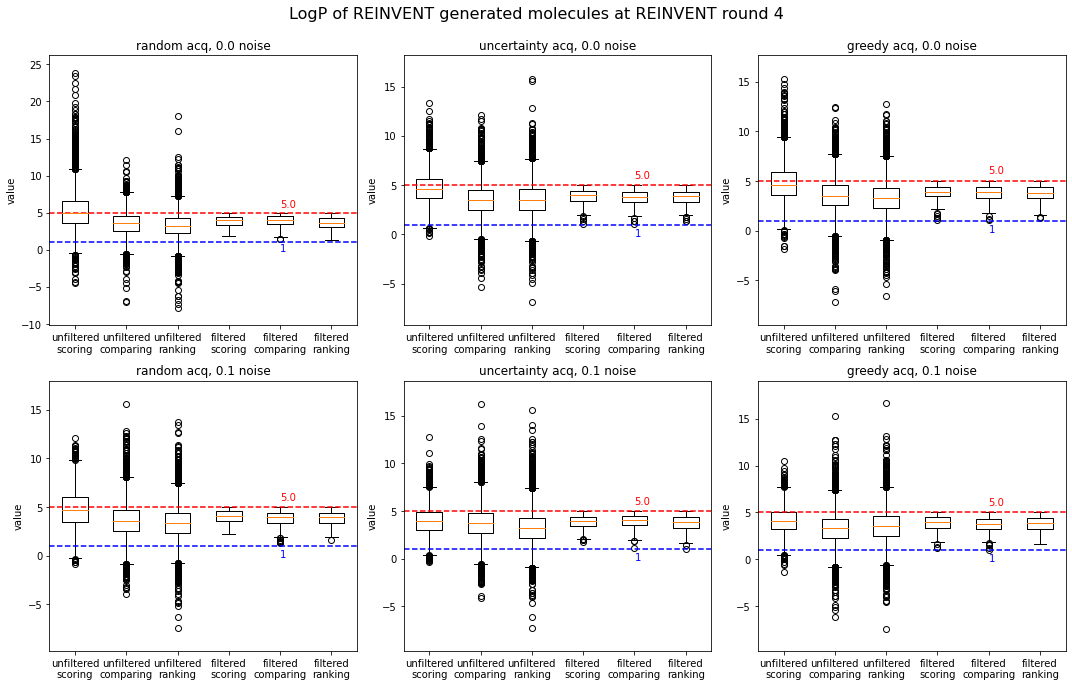

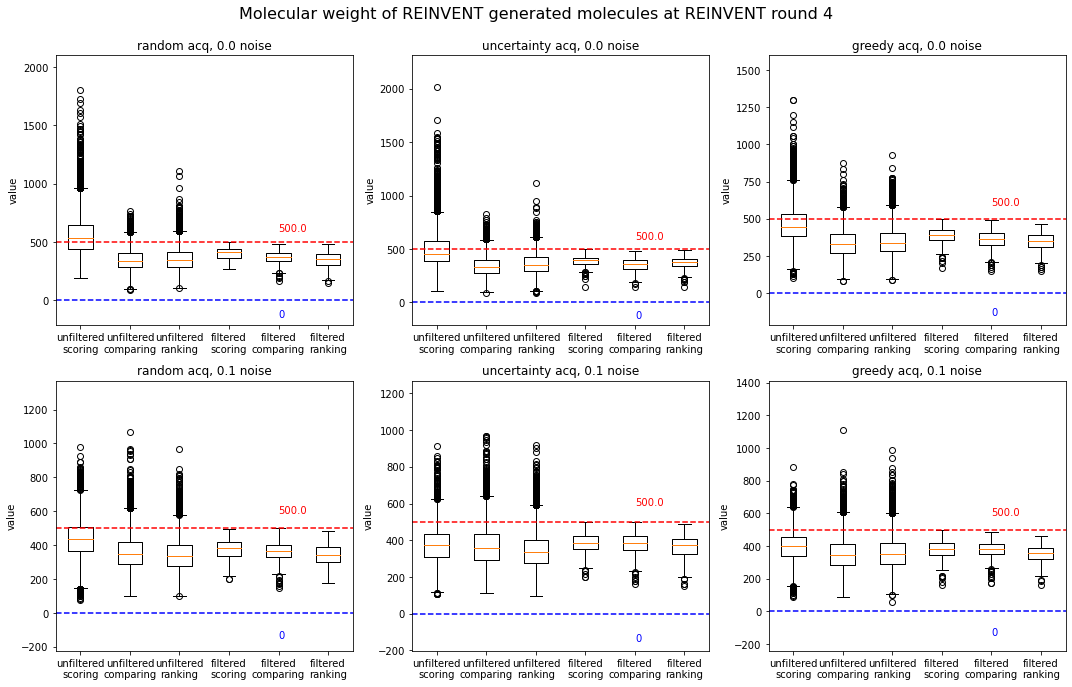

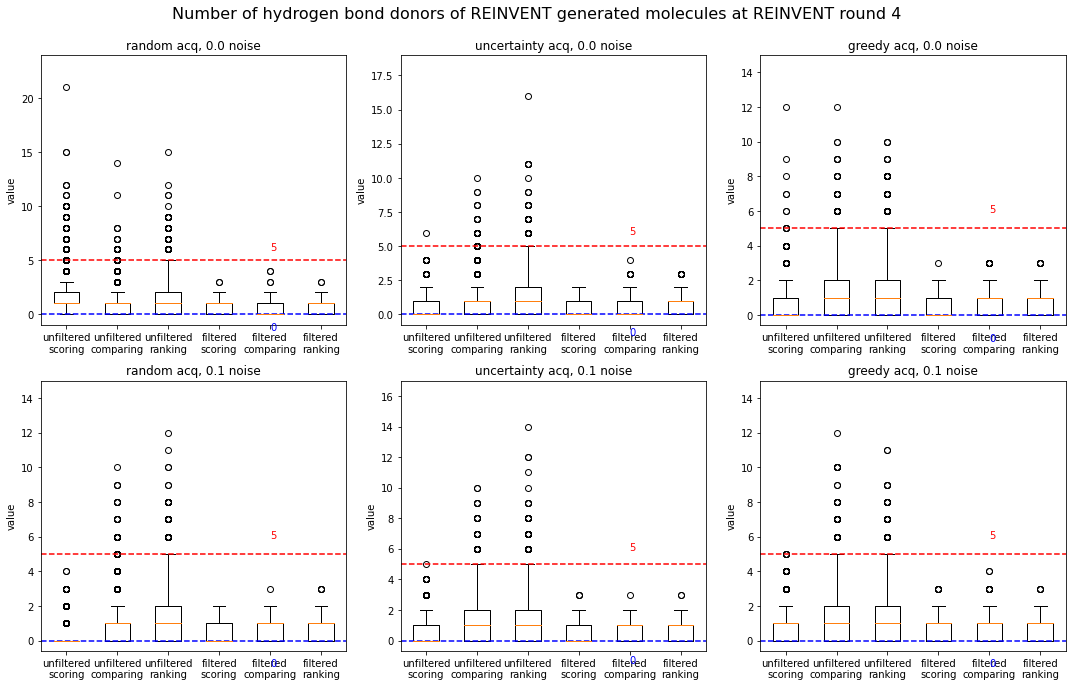

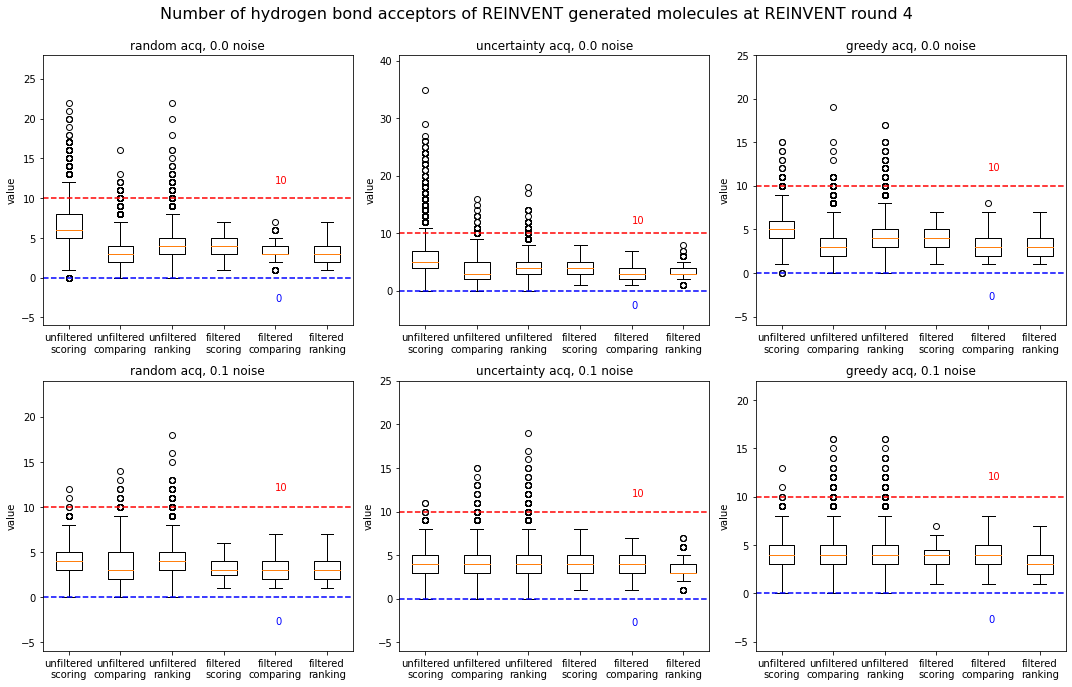

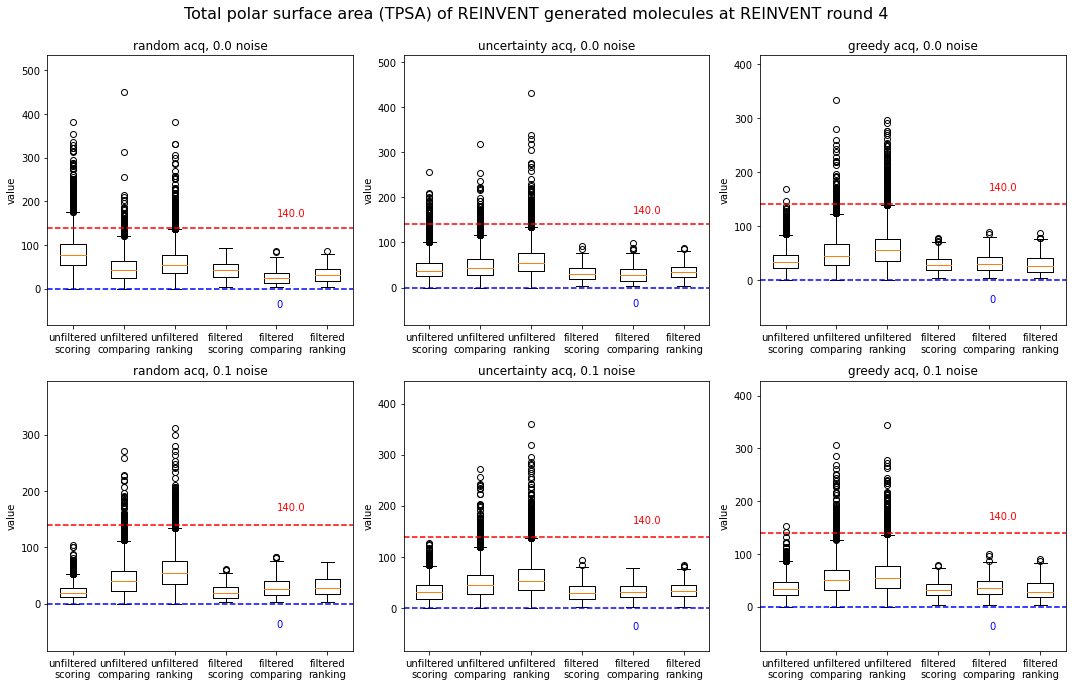

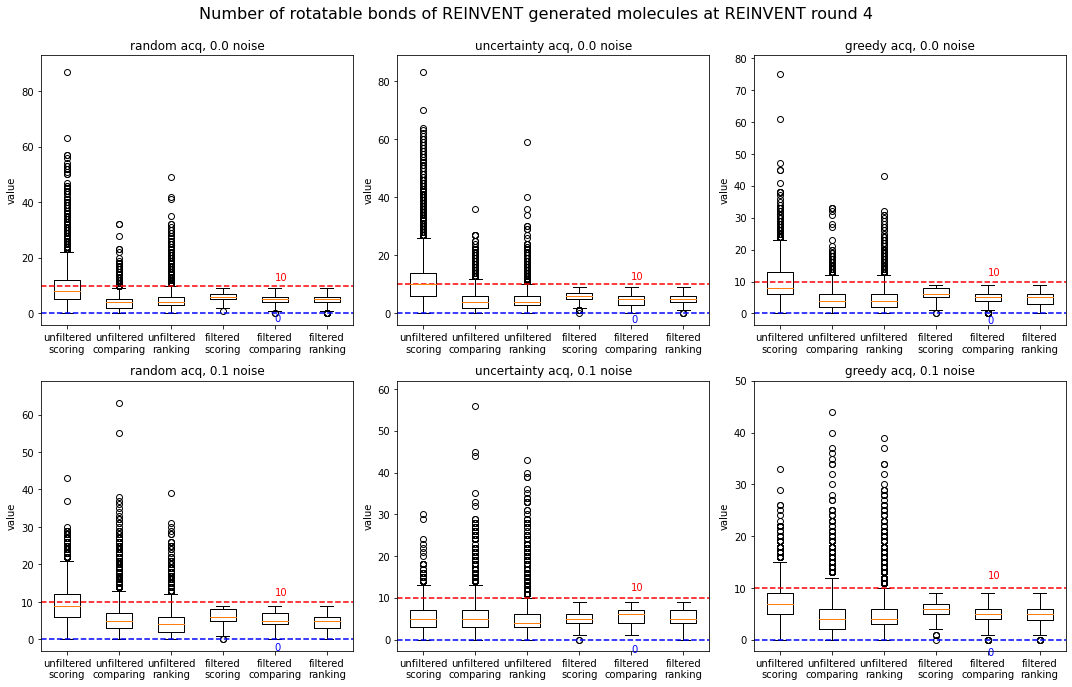

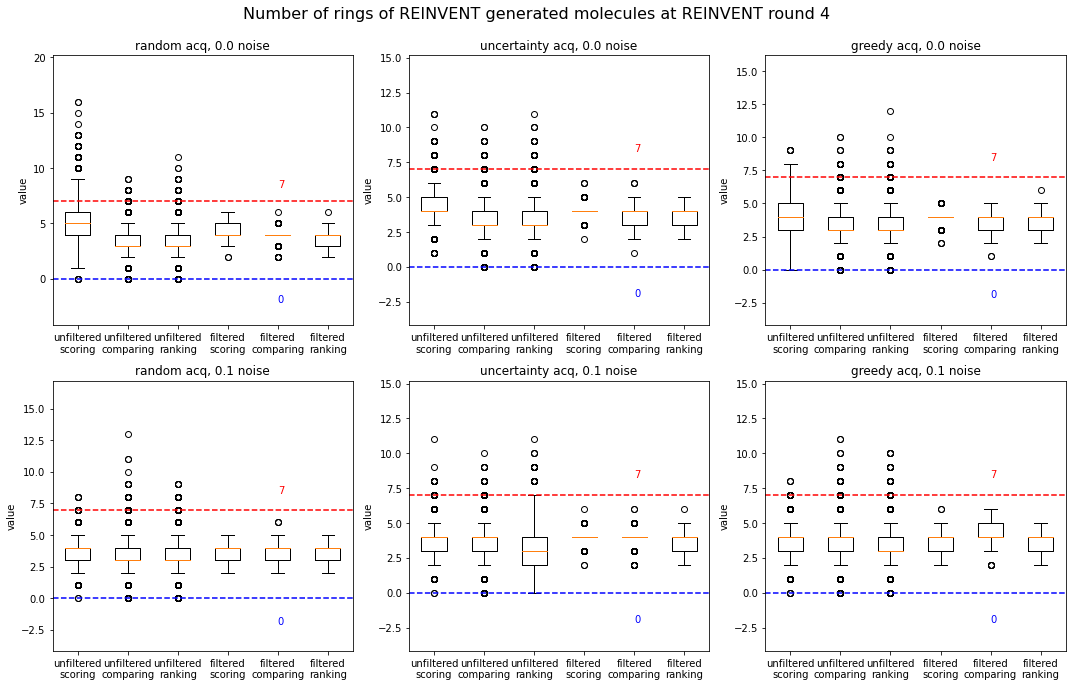

In [40]:
prop_names = ["drd2_proba", "novelty_score", "sa_score", "qed_score", "logP", "mol_weight", "h_donors", "h_acceptors", "tpsa", "rotatable_bonds", "num_rings"]

lower_bounds = {
    "drd2_proba": 0.75,  # No lower limit, set to your preference
    "novelty_score": 0.5,  # No lower limit, set to your preference
    "sa_score": 1.0,  # Lower is better, minimum achievable is 1
    "qed_score": 0.5,  # Minimum acceptable QED score
    "logP": 1,  # No practical lower limit, but logP can be negative
    "mol_weight": 0,  # Molecules can technically weigh very little
    "h_donors": 0,  # Hydrogen bond donors can be zero
    "h_acceptors": 0,  # Hydrogen bond acceptors can be zero
    "tpsa": 0,  # Total polar surface area can be zero
    "rotatable_bonds": 0,  # Rotatable bonds can be zero
    "num_rings": 0  # Number of rings can be zero
}

upper_bounds = {
    "drd2_proba": 1.0,  # Maximum for a probability score
    "novelty_score": 1.0,  # Theoretical maximum for novelty score
    "sa_score": 3.0,  # Upper limit often considered for synthetic accessibility
    "qed_score": 1.0,  # Maximum possible QED score
    "logP": 5.0,  # Lipinski's rule of five
    "mol_weight": 500.0,  # Lipinski's rule of five
    "h_donors": 5,  # Lipinski's rule of five
    "h_acceptors": 10,  # Lipinski's rule of five
    "tpsa": 140.0,  # Veber's rule
    "rotatable_bonds": 10,  # Veber's rule
    "num_rings": 7  # Muegge’s rule
}

prop_name_mapping = {
    "drd2_proba": "DRD2 probility",
    "novelty_score": "Novelty score",
    "sa_score": "Synthetic accessibility (SA) score",
    "qed_score": "Quantitative estimate of drug-likeness (QED) score",
    "logP": "LogP",
    "mol_weight": "Molecular weight",
    "h_donors": "Number of hydrogen bond donors",
    "h_acceptors":  "Number of hydrogen bond acceptors",
    "tpsa": "Total polar surface area (TPSA)",
    "rotatable_bonds": "Number of rotatable bonds",
    "num_rings": "Number of rings"
}

REINVENT_round = 4
REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
for prop_name in prop_names:

    fig, ax = plt.subplots(2, 3, figsize=(15, 10))

    # Flatten ax
    ax = ax.flatten()

    # Subplot title
    fig.suptitle(f"{prop_name_mapping[prop_name]} of REINVENT generated molecules at REINVENT round {REINVENT_round}", fontsize=16)

    index = 0
    for sigma_noise in [0.0, 0.1]:
        for acquisition in ["random", "uncertainty", "greedy"]:
            unfiltered_prop_scoring = models["score_regression"][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name][REINVENT_round_name]
            unfiltered_prop_comparing = models["bradley_terry"][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name][REINVENT_round_name]
            unfiltered_prop_ranking = models["rank_listnet"][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name][REINVENT_round_name]

            filtered_prop_scoring = filtered_models["score_regression"][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name][REINVENT_round_name]
            filtered_prop_comparing = filtered_models["bradley_terry"][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name][REINVENT_round_name]
            filtered_prop_ranking = filtered_models["rank_listnet"][f"acq_{acquisition}_noise_{sigma_noise}"][prop_name][REINVENT_round_name]

            # Creating a box plot
            ax[index].boxplot([unfiltered_prop_scoring, unfiltered_prop_comparing, unfiltered_prop_ranking,
                               filtered_prop_scoring, filtered_prop_comparing, filtered_prop_ranking], 
                              labels=['unfiltered\nscoring', 'unfiltered\ncomparing', 'unfiltered\nranking',
                                        'filtered\nscoring', 'filtered\ncomparing', 'filtered\nranking'])

            # Turn on grid for each subplot
            #ax[index].grid()
            range_lim = (upper_bounds[prop_name] - lower_bounds[prop_name]) * 0.6
            # set only the top limit if only max(unfiltered) > max(filtered)
            if max(max(unfiltered_prop_scoring), max(unfiltered_prop_comparing), max(unfiltered_prop_ranking)) > max(max(filtered_prop_scoring), max(filtered_prop_comparing), max(filtered_prop_ranking)):
                ax[index].set_ylim(top=max(max(unfiltered_prop_scoring), max(unfiltered_prop_comparing), max(unfiltered_prop_ranking)) + range_lim)
            
            # set only the bottom limit if only min(unfiltered) < min(filtered)
            if min(min(unfiltered_prop_scoring), min(unfiltered_prop_comparing), min(unfiltered_prop_ranking)) < min(min(filtered_prop_scoring), min(filtered_prop_comparing), min(filtered_prop_ranking)):
                ax[index].set_ylim(bottom=min(min(unfiltered_prop_scoring), min(unfiltered_prop_comparing), min(unfiltered_prop_ranking)) - range_lim)

                        

            # Draw lower bound with blue color
            ax[index].axhline(y=lower_bounds[prop_name], color='b', linestyle='--')
            # Annotate the lower bound value
            ax[index].text(5, lower_bounds[prop_name] - range_lim * 0.5, f"{lower_bounds[prop_name]}", color='b')

            # Draw upper bound with red color
            ax[index].axhline(y=upper_bounds[prop_name], color='r', linestyle='--')
            # Annotate the upper bound value
            ax[index].text(5, upper_bounds[prop_name] + range_lim * 0.3, f"{upper_bounds[prop_name]}", color='r')

            ax[index].set_title(f"{acquisition} acq, {sigma_noise} noise")
            ax[index].set_ylabel("value")
            
            index += 1

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()